# Summary

## TODO

- Adapt transfer accuracy heatmaps if the method concatenated multiple labeled and/or unlabeled datasets.
- Handle case where train prefix != test prefix.

## Adding a new method

- Update `METHOD_ORDER`.
- Update `method_uses_labeled_and_unlabeled_data` if needed. If the method uses labeled and unlabeled data, it should run eval on both the labeled and unlabeled datasets. In this case, we might want to filter `train == test` (train is the unlabeled dataset and test is the eval dataset).

# Imports

In [1]:
import itertools
import json
import os
import pprint
import re
from collections import defaultdict
from pathlib import Path
from typing import Literal, Optional

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
from IPython.display import display
from tqdm.notebook import tqdm

from utils import plotting as plot_utils
from utils.file_utils import get_model_short_name
from utils_extraction import metrics
from utils_generation import hf_utils
from utils_generation.hf_auth_token import HF_AUTH_TOKEN

In [2]:
# increase figure size to (8, 8)
rcParams["figure.figsize"] = (8, 8)
rcParams["figure.dpi"] = 150
plt.style.use("ggplot")

# Constants

In [3]:
SAVE_DIR = Path("extraction_results")


DEBERTA = "deberta-v2-xxlarge-mnli"
LLAMA_7B_CHAT = "meta-llama/Llama-2-7b-chat-hf"

DATASET_ORDER = (
    "imdb",
    "amazon-polarity",
    "ag-news",
    "dbpedia-14",
    "copa",
    "rte",
    "boolq",
    "qnli",
    "piqa",
)
METHOD_ORDER = (
    "CCS",
    "LR",
    "Random",
    "CCS+LR",
    "CCS-in-LR-span",
    "CCS+LR-in-span",
    "CCS-md",
    "LR-md",
    "Random-md",
    "pseudolabel",
)

# Methods that combine CCS and LR.
CCS_LR_METHODS = ("CCS+LR", "CCS+LR-in-span")

# Utils

## Data loading/preprocessing

In [4]:
# Data loading and preprocessing


def reduce_ccs_lr_method(df):
    method = df["method"].unique()
    if not (len(method) == 1 and method[0] in CCS_LR_METHODS):
        raise ValueError(f"Expected a CCS+LR method, got {method}")

    sup_weight = df["sup_weight"].unique()
    if len(sup_weight) != 1:
        raise ValueError(f"Expected one unique sup_weight, got {sup_weight}")
    sup_weight = sup_weight[0]

    unsup_weight = df["unsup_weight"].unique()
    if len(unsup_weight) != 1:
        raise ValueError(f"Expected one unique unsup_weight, got {unsup_weight}")
    unsup_weight = unsup_weight[0]

    if sup_weight != 0 and unsup_weight != 0:
        return "CCS+LR"
    elif sup_weight != 0 and unsup_weight == 0:
        return "LR"
    elif sup_weight == 0 and unsup_weight != 0:
        return "CCS"
    else:
        raise ValueError("sup_weight and unsup_weight should not both be 0.")


def method_uses_labeled_and_unlabeled_data(method_df: pd.DataFrame) -> bool:
    method = method_df["method"].unique()
    if len(method) != 1:
        raise ValueError(f"Expected one unique method, got {method}")
    method = method[0]

    if method == "CCS+LR":
        method = reduce_ccs_lr_method(method_df)
        if method == "CCS+LR":
            return True
        elif method == "CCS" or method == "LR":
            return False
        else:
            raise ValueError(
                f"Unexpected method returned from reduce_ccs_lr_method: {method}"
            )

    return method in (
        "CCS-in-LR-span",
        "CCS+LR-in-span",
        "CCS-select-LR",
        "pseudolabel",
    )


def filter_train_equals_test_per_method(df, is_ccs_lr_in_span_oracle: bool = False):
    """Filters rows where train == test if the method requires it.

    Condition to filter train == test: the method uses labeled and unlabeled
    data by training on the unlabeled data on which it is tested.

    Example use case: when plotting transfer accuracy of methods that use
    labeled and unlabeled data, we should evaluate the transfer accuracy by
    using the test set as the unlabeled train set, which corresponds to the
    "train" column for such methods.
    """
    method_dfs = []
    for method, method_df in df.groupby("method"):
        if method_uses_labeled_and_unlabeled_data(method_df) and not (
            is_ccs_lr_in_span_oracle and method == "CCS+LR-in-span"
        ):
            method_df = method_df[method_df["train"] == method_df["test"]]

        method_dfs.append(method_df)

    return pd.concat(method_dfs, ignore_index=True)


def check_for_combined_datasets(datasets_str: str) -> bool:
    pattern = r"nolabel_[\w-]+-label_[\w-]+"
    return re.match(pattern, datasets_str) is not None


def parse_combined_datasets(combined_datasets_str):
    if not check_for_combined_datasets(combined_datasets_str):
        return combined_datasets_str, ""

    no_label_train, label_train = combined_datasets_str.split("-label_")
    if not no_label_train.startswith("nolabel_"):
        raise ValueError(
            f"Expected no_label_train to start with 'no_label_', got {no_label_train}"
        )

    train = no_label_train[len("nolabel_") :]
    train_labeled = label_train
    return train, train_labeled


def get_labeled_and_unlabeled_train_data(
    row: pd.Series,
) -> tuple[str, Optional[str]]:
    """Get the main train dataset and the labeled train dataset names.

    Args:
        row: Experiment results DataFrame row.

    Returns:
        A tuple of the main train dataset names and the labeled train dataset
        names. If the method uses only labeled datasets (e.g., LR) or only
        unlabeled datasets (e.g., CCS), these datasets are considered the main
        datasets, and the second element of the tuple is an empty string.
        Otherwise, the first element is the unlabeled dataset and the second
        element is the labeled dataset (e.g., for CCS+LR).
    """
    return list(parse_combined_datasets(row.train))


def flatten_dictionary(d, parent_key="", sep="."):
    """
    Flatten a nested dictionary.

    Args:
        d (dict): The nested dictionary to flatten.
        parent_key (str): The parent key (used in recursion).
        sep (str): The separator for joining keys.

    Returns:
        dict: Flattened dictionary.
    """
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dictionary(v, parent_key=new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)


def get_orthogonal_directions_dataset(load_orthogonal_directions_dir: str) -> str:
    """Return the dataset for which the orthogonal directions were computed."""
    combined_datasets_str = os.path.basename(
        os.path.normpath(load_orthogonal_directions_dir)
    )
    return parse_combined_datasets(combined_datasets_str)[1]


def reformat_oracle_lr_in_span_df(df):
    """Reformat the train and train_labeled columns for the oracle LR in span method."""
    rest_df = df[df["method"] != "CCS+LR-in-span"].copy()
    df = df[df["method"] == "CCS+LR-in-span"].copy()
    df = df[df["train"] == df["train_labeled"]]
    df = df[df["train"] == df["test"]]
    df = df.copy()
    df["train"] = df.load_orthogonal_directions_dir.apply(
        get_orthogonal_directions_dataset
    )
    df["train_labeled"] = df["train"]

    df = pd.concat([df, rest_df], ignore_index=True)
    return df


def load_eval_csvs(
    base_path,
    pattern: Optional[str] = None,
    model_filter=None,
    train_set_filter=None,
    eval_set_filter=None,
    use_latest_run_id: bool = True,
    use_best_in_domain_acc: bool = True,
    is_ccs_lr_in_span_oracle: bool = False,
    verbose: bool = True,
) -> dict[str, pd.DataFrame]:
    base_path = Path(base_path)
    if pattern:
        if not pattern.endswith("eval.csv"):
            pattern = os.path.join(pattern, "**/eval.csv")
    else:
        pattern = "**/eval.csv"
    print("pattern:", pattern)
    csv_files = base_path.glob(pattern)
    exp_name_to_dfs = defaultdict(list)

    for csv_file in tqdm(list(csv_files)):
        # Extract components from the path
        parts = csv_file.parts
        experiment_name = os.path.join(*parts[1:-7])
        train_set = parts[-6]
        seed = parts[-5].split("_")[-1]
        run_id = parts[-4]
        eval_dataset = parts[-2]

        # Read the CSV
        df = pd.read_csv(csv_file)

        # Sanity checks
        if not all(df["train"] == train_set) or not all(df["test"] == eval_dataset):
            raise ValueError(f"Sanity check failed for {csv_file}")

        # Set "train" and "train_labeled" columns based on the "train" dataset
        # string, which may combine labeled and unlabeled datasets (e.g., for
        # CCS+LR method).
        train_and_train_labeled_df = pd.DataFrame(
            list(df.apply(get_labeled_and_unlabeled_train_data, axis=1)),
            columns=["train", "train_labeled"],
        )
        df["train"] = train_and_train_labeled_df["train"]
        train_col_loc = df.columns.get_loc("train")
        df.insert(
            train_col_loc + 1,
            "train_labeled",
            train_and_train_labeled_df["train_labeled"],
        )

        # Add new columns
        df["experiment_name"] = experiment_name
        df["seed"] = int(seed)
        df["run_id"] = int(run_id)

        # Add columns from config.
        eval_dir = os.path.join(*csv_file.parts[:-3])
        config_path = Path(eval_dir) / "config.json"
        if config_path.exists():
            with open(config_path, "r") as f:
                config = json.load(f)

            # Remove type annotations.
            del config["__annotations__"]
            config = flatten_dictionary(config)

            for key, value in config.items():
                # If the value is an iterable, repeat it for each row.
                # Otherwise, pandas assumes len(value) == len(df).
                if isinstance(value, (list, tuple)):
                    value = [value] * len(df)
                df[key] = value

        # Reformat the train and train_labeled columns for the oracle LR in span method.
        if "CCS+LR-in-span" in df.method.unique() and is_ccs_lr_in_span_oracle:
            df = reformat_oracle_lr_in_span_df(df)

        exp_name_to_dfs[experiment_name].append(df)

    if not exp_name_to_dfs:
        raise ValueError(f"No eval CSV files found in {base_path}.")

    exp_name_to_final_df = {}
    for exp_name, dfs in exp_name_to_dfs.items():
        # Concatenate all dataframes
        exp_df = pd.concat(dfs, ignore_index=True)

        # Optional filtering
        if model_filter:
            exp_df = exp_df[exp_df["model"] == model_filter]
        if train_set_filter:
            exp_df = exp_df[exp_df["train"] == train_set_filter]
        if eval_set_filter:
            exp_df = exp_df[exp_df["test"] == eval_set_filter]

        if use_latest_run_id:
            exp_df = get_latest_run_id_df(exp_df)
        if use_best_in_domain_acc:
            exp_df = get_best_metric_by_acc_df(exp_df)

        exp_name_to_final_df[exp_name] = exp_df

    return exp_name_to_final_df


def get_latest_run_id_df(df):
    latest_group_dfs = []
    for key, group_df in df.groupby(
        [
            "model",
            "prefix",
            "method",
            "mode",
            "train",
            "train_labeled",
            "test",
            "seed",
            "num_orthogonal_directions",
            "load_orthogonal_directions_dir",
        ],
        dropna=False,
    ):
        max_run_id = group_df.run_id.max()
        group_df = group_df[group_df.run_id == max_run_id]
        latest_group_dfs.append(group_df)

    latest_run_df = pd.concat(latest_group_dfs, ignore_index=True)

    for key, group_df in latest_run_df.groupby(
        [
            "model",
            "prefix",
            "method",
            "mode",
            "train",
            "train_labeled",
            "test",
            "prompt_level",
            "location",
            "layer",
            "seed",
            "num_orthogonal_directions",
            "load_orthogonal_directions_dir",
        ],
        dropna=False,
    ):
        num_unique_run_ids = group_df.run_id.nunique()
        if num_unique_run_ids != 1:
            raise ValueError(
                f"Expected 1 unique run_id, but got {num_unique_run_ids} for {key}"
            )

    return latest_run_df


def get_dataset_names_from_str(train_sets_str: str) -> list[str]:
    return train_sets_str.split("+")


def get_best_metric_by_acc_df(df):
    """Flip metrics for each experiment if it improves in-domain accuracy.

    Use the in-domain accuracy to decide whether to flip the accuracy instead of
    computing max(acc, 1-acc) for test datasets even if the in-domain accuracy
    is greater than 0.5. Also flips the ECE if the flipped accuracy is better.

    In-domain accuracy for a given dataset is computed as the mean accuracy over
    all the prompts when evaluated on that same dataset. The model, prefix,
    method, token location, layer, and seed are held constant.
    """
    processed_df = []
    for key, train_df in df.groupby(
        [
            "model",
            "prefix",
            "method",
            "mode",
            "train",
            "train_labeled",
            "location",
            "layer",
            "seed",
            "num_orthogonal_directions",
        ],
        dropna=False,
    ):
        assert len(train_df["train"].unique()) == 1
        train_ds_str = train_df["train"].iloc[0]
        train_ds_list = get_dataset_names_from_str(train_ds_str)

        assert len(train_df["train_labeled"].unique()) == 1
        train_labeled_ds_str = train_df["train_labeled"].iloc[0]
        train_labeled_ds_list = (
            get_dataset_names_from_str(train_labeled_ds_str)
            if train_labeled_ds_str is not None
            else []
        )

        # If the method uses both labeled and unlabeled datasets, only use the
        # labeled datasets as the "in-domain" datasets to decide whether to flip
        # the accuracy.
        in_domain_train_ds_list = (
            train_labeled_ds_list if train_labeled_ds_str else train_ds_list
        )
        if not in_domain_train_ds_list:
            raise ValueError(f"No train datasets found for {key}")

        # If trained on multiple datasets, use the mean accuracy on
        # those datasets to decide whether to flip the accuracy. Otherwise,
        # use the accuracy of the single dataset.
        in_domain_train_df = train_df[train_df["test"].isin(in_domain_train_ds_list)]
        if len(in_domain_train_df) == 0:
            raise ValueError(
                f"No in-domain train datasets found for {key} with train "
                f"datasets {in_domain_train_ds_list}"
            )
        group_num_unique_in_domain_prompts = in_domain_train_df.prompt_level.nunique()
        num_unique_in_domain_prompts = df[
            df["test"].isin(in_domain_train_ds_list)
        ].prompt_level.nunique()
        if group_num_unique_in_domain_prompts != num_unique_in_domain_prompts:
            raise ValueError(
                f"Expected {num_unique_in_domain_prompts} unique "
                f"prompts in the group df for key {key} to match the "
                "number of unique prompt indices in the whole df where "
                f"test == {train_ds_str}, but got "
                f"{group_num_unique_in_domain_prompts}."
            )

        in_domain_acc = in_domain_train_df["accuracy"].mean()
        if in_domain_acc < 0.5:
            train_df["accuracy"] = 1 - train_df["accuracy"]
            train_df["ece"] = train_df["ece_flip"]

        del train_df["ece_flip"]
        processed_df.append(train_df)

    return pd.concat(processed_df)


# Inference

InferenceMethodType = Literal["auto", "mean", "class0", "class1"]


def get_single_class_probs(
    probs_df: np.ndarray,
    method: str,
    inference_method: InferenceMethodType = "auto",
):
    """Returns the predicted probability for a single class."""
    if method == "LR":
        if inference_method not in ("auto", "class1"):
            raise ValueError(
                f"Unsupported inference method {inference_method} for method {method}"
            )
        # Older versions of the saved LR probabilities used "prediction" as the
        # column name, and newer versions use "prob".
        probs = probs_df.prob if "prob" in probs_df else probs_df.prediction
    elif method == "CCS":
        if inference_method == "auto" or inference_method == "mean":
            # Arbitrarily treat p0 as 0 and p1 as 1 to match the original CCS
            # implementation, which computes (p0 + 1 - p1) / 2 but then checks
            # if this value is < 0.5 intead of > 0.5.
            probs = (probs_df.p1 + 1 - probs_df.p0) / 2
        elif inference_method == "class0":
            probs = probs_df.p0
        elif inference_method == "class1":
            probs = probs_df.p1
    else:
        raise ValueError(f"Unknown method {method}")

    return probs.values.astype(np.float32)


# ECE


def make_ece_df(
    save_dir: str,
    experiment_name: str,
):
    base_path = Path(save_dir) / experiment_name
    probs_files = base_path.glob("**/prob*.csv")

    all_data = []
    for probs_file in probs_files:
        # Extract components from the path
        parts = probs_file.parts
        model = parts[-7]
        train_set = parts[-6]
        seed = int(parts[-5].split("_")[-1])
        run_id = int(parts[-4])
        eval_set = parts[-2]
        probs_str, method, prompt = parts[-1].split(".")[0].split("_")
        prompt = int(prompt)

        # Read the CSV
        df = pd.read_csv(probs_file)

        probs = get_single_class_probs(df, method)
        preds = (probs > 0.5).astype(int)
        labels = df.label.values
        acc = (preds == labels).mean()
        ece, bin_mean_probs, bin_mean_labels = metrics.expected_calibration_error(
            probs, labels
        )
        ece_flip, bin_mean_probs_flip, bin_mean_labels_flip = (
            metrics.expected_calibration_error(1 - probs, labels)
        )
        all_data.append(
            [
                model,
                method,
                train_set,
                eval_set,
                prompt,
                seed,
                run_id,
                acc,
                ece,
                bin_mean_probs,
                bin_mean_labels,
                False,
            ]
        )
        all_data.append(
            [
                model,
                method,
                train_set,
                eval_set,
                prompt,
                seed,
                run_id,
                1 - acc,
                ece_flip,
                bin_mean_probs_flip,
                bin_mean_labels_flip,
                True,
            ]
        )

    ece_df = pd.DataFrame(
        all_data,
        columns=[
            "model",
            "method",
            "train",
            "test",
            "prompt",
            "seed",
            "run_id",
            "acc",
            "ece",
            "bin_mean_probs",
            "bin_mean_labels",
            "flip_probs",
        ],
    )
    return ece_df


def method_uses_orthogonal_directions(method):
    return method in ("CCS+LR", "CCS-in-LR-span", "CCS-select-LR")


def compute_mean_std_metric_df(df, metric="accuracy"):
    """Compute the mean and standard deviation of the metric."""
    return (
        df.groupby(
            [
                "model",
                "method",
                "prefix",
                "mode",
                "train",
                "train_labeled",
                "test",
                "location",
                "layer",
                "num_orthogonal_directions",
                "sup_weight",
                "unsup_weight",
            ],
            dropna=False,
        )
        .agg(mean=(metric, "mean"), std=(metric, "std"))
        .reset_index()
    )


def make_train_test_df(df: pd.DataFrame, train_col: str) -> pd.DataFrame:
    # Modify the pivot table creation to include both mean accuracy and
    # std accuracy in the annotations
    pivot_table_mean = df.pivot(index=train_col, columns="test", values="mean").reindex(
        index=DATASET_ORDER, columns=DATASET_ORDER
    )
    pivot_table_std = df.pivot(index=train_col, columns="test", values="std").reindex(
        index=DATASET_ORDER, columns=DATASET_ORDER
    )

    # Reorder the pivot tables according to DATASET_ORDER
    pivot_table_mean_ordered = pivot_table_mean.reindex(
        index=DATASET_ORDER, columns=DATASET_ORDER
    )
    pivot_table_std_ordered = pivot_table_std.reindex(
        index=DATASET_ORDER, columns=DATASET_ORDER
    )

    return pivot_table_mean_ordered, pivot_table_std_ordered


def train_col_name_for_transfer_acc(df: pd.DataFrame) -> str:
    method = df["method"].unique()
    if len(method) != 1:
        raise ValueError(f"Expected one unique method, got {method}")
    method = method[0]

    if method in CCS_LR_METHODS:
        method = reduce_ccs_lr_method(df)
        if method == "LR" or method == "CCS+LR":
            return "train_labeled"
        elif method == "CCS":
            return "train"
        else:
            raise ValueError(f"Unexpected method {method}")
    elif method in ("LR", "CCS"):
        return "train"
    elif method == "pseudolabel":
        return "train_labeled"
    else:
        raise NotImplementedError(f"Unclear what train column should be for {method}.")


def make_train_test_metric_dfs_dict(df: pd.DataFrame, metric: str) -> dict:
    """Create train-test metric matrix grouped by separate categories.

    Groups the DataFrame by model, method, and num_orthogonal_directions.

    Returns:
        Nested dictionary where the keys are (model, method, num_orthogonal_directions) and the value is a tuple containing the
        mean and standard deviation train-test metric matrix DataFrames.
    """
    df_dict = {}

    # Calculate mean accuracy and standard deviation of accuracy for each combination
    agg_df = compute_mean_std_metric_df(df, metric=metric)

    new_methods = tuple(set(agg_df.method.unique()) - set(METHOD_ORDER))
    method_order = METHOD_ORDER + new_methods

    for model in agg_df.model.unique():
        if model not in df_dict:
            df_dict[model] = {}

        model_df = agg_df[agg_df["model"] == model]
        methods = model_df.method.unique()
        # Sort methods by METHOD_ORDER.
        methods = sorted(methods, key=lambda x: method_order.index(x))
        for method in methods:
            if method not in df_dict[model]:
                df_dict[model][method] = {}
            df = model_df[model_df["method"] == method]
            if len(df) == 0:
                continue

            if method_uses_orthogonal_directions(method):
                group_keys_dfs = df.groupby(["num_orthogonal_directions"])
            else:
                group_keys_dfs = [(None, df)]

            for num_orthogonal_directions, df in group_keys_dfs:
                # These columns should be unique for a given model and method.
                # If the method uses labeled and unlabeled data, "train_labeled" and
                # "train" are not unique because train_labeled is the pivot column
                # and train == test for each test set since train is the unlabeled
                # train set. Otherwise, if the method uses only labeled or only
                # unlabeled data, we ignore whether there is a unique
                # train or train_labeled for each group because only one of them
                # is used for the algorithm.
                expected_unique_cols = ["prefix", "mode", "location", "layer"]
                train_col = train_col_name_for_transfer_acc(df)
                # TODO: delete this block.
                # if method_uses_labeled_and_unlabeled_data(df):
                #     train_col = "train_labeled"
                # else:
                #     # Otherwise, the "train_labeled" column should also be unique
                #     # because it is empty.
                #     train_col = "train"
                #     expected_unique_cols.append("train_labeled")

                for col in expected_unique_cols:
                    if df[col].nunique() > 1:
                        raise ValueError(
                            f"Expected one unique '{col}' dataset, got "
                            f"{df[col].unique()} for model={model}, method={method}"
                        )

                pivot_table_mean_ordered, pivot_table_std_ordered = make_train_test_df(
                    df, train_col
                )

                df_dict[model][method][num_orthogonal_directions] = (
                    pivot_table_mean_ordered,
                    pivot_table_std_ordered,
                )

    return df_dict


def compute_mean_train_test_acc_df_over_nonunique_cols(df):
    """Computes the mean accuracy over non-unique columns in the DataFrame.

    Groups by "train", "test", "prompt_level", and any other columns that have
    only one unique value. For each group, computes the mean accuracy, and then
    concatenates the result.

    Example use case: if CCS was run over multiple train_labeled datasets, which
    are unused by CCS, take the mean accuracy for each (train, test) pair.
    """
    group_cols = ["train", "test", "prompt_level"]
    for col in df.columns:
        try:
            n_unique = df[col].nunique()
            if n_unique == 1:
                group_cols.append(col)
                # print(col, n_unique)
        except TypeError:
            # print(col, "TypeError")
            pass

    group_cols = list(set(group_cols))

    mean_acc_rows = []
    group_cols = [
        "model",
        "train_prefix",
        "test_prefix",
        "method",
        "prompt_level",
        "mode",
        "train",
        "test",
        "location",
        "layer",
    ]
    for key, group_df in df.groupby(group_cols):
        mean_acc = group_df["accuracy"].mean()
        if len(group_df) == 1:
            mean_acc_group_df = group_df
        else:
            mean_acc_group_df = group_df[group_df["train"] == group_df["train_labeled"]]

        if len(mean_acc_group_df) != 1:
            raise ValueError(
                f"Expected mean_acc_group_df to have 1 row, got {len(mean_acc_group_df)}"
            )

        mean_acc_group_df = mean_acc_group_df.copy()
        mean_acc_group_df["accuracy"] = mean_acc
        mean_acc_rows.append(mean_acc_group_df)

    return pd.concat(mean_acc_rows)

## Analysis

In [5]:
def get_in_domain_df(df, train_col):
    return df[df[train_col] == df["test"]]


def get_ood_df(df, train_col):
    return df[df[train_col] != df["test"]]


def print_acc_stats_for_df(df):
    train_col = train_col_name_for_transfer_acc(df)
    train_test_metric_dfs_dict = make_train_test_metric_dfs_dict(df, metric="accuracy")
    for model, method_df in train_test_metric_dfs_dict.items():
        for method, num_orth_dirs_df in method_df.items():
            for num_orth_dirs, (mean_df, std_df) in num_orth_dirs_df.items():
                melt_df = pd.melt(mean_df.reset_index(), id_vars=[train_col])
                in_domain_acc = melt_df[melt_df[train_col] == melt_df["test"]][
                    "value"
                ].mean()
                ood_acc = melt_df[melt_df[train_col] != melt_df["test"]]["value"].mean()
                exp_title = f"{model} - {method}"
                # if num_orth_dirs is not None:
                #     exp_title += f" - {num_orth_dirs} Orthogonal Directions"
                if print:
                    print(exp_title)
                    print(f"In-domain accuracy: {in_domain_acc:.4f}")
                    print(f"OOD accuracy: {ood_acc:.4f}")


def compare_accuracies(
    df1,
    df2,
    train_col1,
    train_col2,
    acc_threshold=0.7,
    is_ccs_lr_in_span_oracle: bool = False,
):
    df1 = filter_train_equals_test_per_method(
        df1, is_ccs_lr_in_span_oracle=is_ccs_lr_in_span_oracle
    )
    df2 = filter_train_equals_test_per_method(
        df2, is_ccs_lr_in_span_oracle=is_ccs_lr_in_span_oracle
    )
    agg_df1 = compute_mean_std_metric_df(df1, metric="accuracy")
    agg_df2 = compute_mean_std_metric_df(df2, metric="accuracy")

    # Rename train columns of both DataFrames to "train_" to make it a unique
    # column name that does not conflict with other columns. Do this before
    # making the train-test matrix DataFrames in order to be able to melt them
    # correctly later.
    agg_df1 = agg_df1.rename(columns={train_col1: "train_"})
    agg_df2 = agg_df2.rename(columns={train_col2: "train_"})

    pivot_df1, _ = make_train_test_df(agg_df1, "train_")
    pivot_df2, _ = make_train_test_df(agg_df2, "train_")

    diff_pivot_df = pivot_df1 - pivot_df2
    print("Number of NaNs in diff_pivot_df:", diff_pivot_df.isna().sum().sum())
    high_acc_diff_pivot_df = diff_pivot_df[
        (pivot_df1 >= acc_threshold) | (pivot_df2 >= acc_threshold)
    ]

    diff_df = diff_pivot_df.reset_index().melt(
        id_vars=["train_"], value_name="accuracy"
    )
    in_domain_diff_df = get_in_domain_df(diff_df, "train_")
    ood_diff_df = get_ood_df(diff_df, "train_")

    frac_acc1_better = (diff_df["accuracy"] > 0).mean()
    frac_acc1_better_in_domain = (in_domain_diff_df["accuracy"] > 0).mean()
    frac_acc1_better_ood = (ood_diff_df["accuracy"] > 0).mean()

    high_acc_diff_df = high_acc_diff_pivot_df.reset_index().melt(
        id_vars=["train_"], value_name="accuracy"
    )
    high_acc_diff_df.dropna(subset="accuracy", inplace=True)
    high_acc_in_domain_diff_df = get_in_domain_df(high_acc_diff_df, "train_")
    high_acc_ood_diff_df = get_ood_df(high_acc_diff_df, "train_")

    high_acc_frac_acc1_better = (high_acc_diff_df["accuracy"] > 0).mean()
    high_acc_frac_acc1_better_in_domain = (
        high_acc_in_domain_diff_df["accuracy"] > 0
    ).mean()
    high_acc_frac_acc1_better_ood = (high_acc_ood_diff_df["accuracy"] > 0).mean()

    return dict(
        frac_acc1_better=frac_acc1_better,
        frac_acc1_better_in_domain=frac_acc1_better_in_domain,
        frac_acc1_better_ood=frac_acc1_better_ood,
        high_acc_frac_acc1_better=high_acc_frac_acc1_better,
        high_acc_frac_acc1_better_in_domain=high_acc_frac_acc1_better_in_domain,
        high_acc_frac_acc1_better_ood=high_acc_frac_acc1_better_ood,
    )


def get_train_to_orth_dirs_dict(paths):
    train_to_orth_dirs = {}

    for path in paths:
        orthogonal_directions = np.load(path)
        with open(Path(*path.parts[:-2]) / "config.json", "r") as f:
            config = json.load(f)

        sup_train_ds = config["labeled_datasets"]
        if isinstance(sup_train_ds, (list, tuple)):
            assert len(sup_train_ds) == 1
            sup_train_ds = sup_train_ds[0]

        if sup_train_ds in train_to_orth_dirs:
            raise ValueError(
                f"Duplicate orthogonal directions found for {sup_train_ds}"
            )
        train_to_orth_dirs[sup_train_ds] = orthogonal_directions

    return train_to_orth_dirs


def make_inner_prods_df(paths) -> pd.DataFrame:
    train_to_orth_dirs = get_train_to_orth_dirs_dict(paths)
    rows = []
    for ds1, ds2 in itertools.product(train_to_orth_dirs, repeat=2):
        inner_prods = train_to_orth_dirs[ds1] @ train_to_orth_dirs[ds2].T
        for i in range(inner_prods.shape[0]):
            for j in range(inner_prods.shape[1]):
                rows.append(
                    {
                        "ds1": ds1,
                        "ds2": ds2,
                        "dir1_idx": i,
                        "dir2_idx": j,
                        "inner_prod": inner_prods[i, j],
                    }
                )

    inner_prods_df = pd.DataFrame(rows)
    return inner_prods_df

## Plotting

In [28]:
def plot_heatmap(
    df: pd.DataFrame,
    metric: str,
    std_annot: bool = False,
    heatmap_kwargs: Optional[dict] = None,
    xlabel: str = "Test Dataset",
    ylabel: str = "Train Dataset",
    title: Optional[str] = None,
    add_num_orthogonal_directions_to_title: bool = False,
    show: bool = True,
):
    mean_std_df_dict = make_train_test_metric_dfs_dict(df, metric=metric)
    for model, method_dict in mean_std_df_dict.items():
        for method, num_orth_dirs_dict in method_dict.items():
            for num_orth_dirs, (
                mean_pivot_df,
                std_pivot_df,
            ) in num_orth_dirs_dict.items():
                # Get the in-domain accuracy from the main diagonal.
                in_domain_acc = pd.Series(
                    data=[mean_pivot_df.at[i, i] for i in mean_pivot_df.index],
                    index=mean_pivot_df.index,
                    name="No Transfer",
                )

                # Calculate the average of each column
                column_avg = mean_pivot_df.mean(axis=0)
                column_avg.name = "Average"
                # Calculate the average of each row
                row_avg = mean_pivot_df.mean(axis=1)
                row_avg.name = "Average"

                # Ignore the main diagonal by setting diagonal values to NaN for non-square matrices
                no_diag_mean_pivot_df = mean_pivot_df.copy()
                for i in no_diag_mean_pivot_df.index:
                    if i in no_diag_mean_pivot_df.columns:
                        no_diag_mean_pivot_df.at[i, i] = np.nan

                # Calculate the average of each column and row excluding the main diagonal
                column_avg_no_diag = no_diag_mean_pivot_df.mean(axis=0)
                column_avg_no_diag.name = "Transfer Average"
                row_avg_no_diag = no_diag_mean_pivot_df.mean(axis=1)
                row_avg_no_diag.name = "Transfer Average"

                # Append the row averages as new columns to the right of the
                # DataFrame and the column averages as new rows at the bottom
                # of the DataFrame.
                mean_pivot_df[row_avg.name] = row_avg
                mean_pivot_df = mean_pivot_df.append(column_avg)
                mean_pivot_df[row_avg_no_diag.name] = row_avg_no_diag
                mean_pivot_df = mean_pivot_df.append(column_avg_no_diag)
                # Append the no transfer row (in-domain) accuracy.
                mean_pivot_df = mean_pivot_df.append(in_domain_acc)

                # Combine mean and std into a single string for each cell annotation
                annotations = mean_pivot_df.applymap("{:.2f}".format)
                if std_annot:
                    annotations += "+-" + std_pivot_df.applymap("{:.2f}".format)
                    annot_size = 6
                else:
                    annot_size = 10

                # Create the heatmap with custom annotations
                # Make a figure if an axis is not provided.
                if "ax" in heatmap_kwargs:
                    ax = heatmap_kwargs.pop("ax")
                else:
                    fig, ax = plt.subplots(figsize=(10, 8))

                heatmap_kwargs = heatmap_kwargs or {}
                sns.heatmap(
                    mean_pivot_df,
                    annot=annotations,
                    fmt="",
                    cmap="viridis",
                    cbar_kws={"label": f"Mean {metric.capitalize()}"},
                    annot_kws={"size": annot_size},
                    square=True,
                    ax=ax,
                    **heatmap_kwargs,
                )

                # Adding title and axis labels
                num_orthogonal_directions_str = (
                    f" (num_orth_dirs={num_orth_dirs})"
                    if num_orth_dirs is not None
                    and add_num_orthogonal_directions_to_title
                    else ""
                )
                title = title or f"{model} - {method}{num_orthogonal_directions_str}"
                ax.set_title(title)
                ax.set_xlabel(xlabel)
                ax.set_ylabel(ylabel)

                # Show the plot
                if show:
                    plt.show()


def heatmap_subplots(
    dfs: list[pd.DataFrame],
    titles: Optional[list[str]] = None,
    filter_train_equals_test: bool = True,
    dedup_ccs_train_labeled_cols: bool = True,
):
    num_cols = 2
    num_rows = len(dfs) // num_cols
    if len(dfs) % num_cols != 0:
        num_rows += 1
    fig, axs = plt.subplots(
        num_rows, num_cols, figsize=(9 * num_cols, 9 * num_rows), squeeze=False
    )

    for i, df in enumerate(dfs):
        row = i // num_cols
        col = i % num_cols
        ax = axs[row, col]

        if filter_train_equals_test:
            df = filter_train_equals_test_per_method(
                df, is_ccs_lr_in_span_oracle=is_ccs_lr_in_span_oracle
            )

        if (
            df["method"].unique() == ["CCS+LR"]
            and reduce_ccs_lr_method(df) == "CCS"
            and dedup_ccs_train_labeled_cols
        ):
            df = compute_mean_train_test_acc_df_over_nonunique_cols(df)

        # Calculate mean accuracy and standard deviation of accuracy for each combination
        agg_df = compute_mean_std_metric_df(df, metric="accuracy")
        train_col = train_col_name_for_transfer_acc(agg_df)
        in_domain_acc = agg_df[agg_df[train_col] == agg_df["test"]]["mean"].mean()
        ood_acc = agg_df[agg_df[train_col] != agg_df["test"]]["mean"].mean()

        title = (
            f"{titles[i]} | in-domain: {in_domain_acc:.4f} | OOD: {ood_acc:.4f}"
            if titles is not None
            else None
        )
        show_cbar = True  # col == num_cols - 1
        heatmap_kwargs = {"ax": ax, "vmin": 0.5, "vmax": 1, "cbar": show_cbar}
        xlabel = "Test Dataset" if row == num_rows - 1 else ""
        ylabel = "Train Dataset" if col == 0 else ""
        plot_heatmap(
            df,
            "accuracy",
            std_annot=False,
            heatmap_kwargs=heatmap_kwargs,
            xlabel=xlabel,
            ylabel=ylabel,
            title=title,
            show=False,
        )

    plt.subplots_adjust(hspace=0.35, wspace=0.2)

    plt.show()


def plot_inner_prods_heatmap(df: pd.DataFrame, needs_pivot: bool = True):
    plot_heatmap_from_df(
        df,
        needs_pivot=needs_pivot,
        pivot_values="inner_prod",
        cbar_label="Inner Product",
        title="Inner Product of Orthogonal LR Directions",
    )


def plot_heatmap_from_df(
    df: pd.DataFrame,
    needs_pivot: bool = True,
    pivot_values: Optional[str] = None,
    cbar_label: Optional[str] = None,
    title: Optional[str] = None,
):
    if needs_pivot:
        if pivot_values is None:
            raise ValueError("If needs_pivot is True, pivot_values must be provided.")
        df = df.pivot(index="ds1", columns="ds2", values=pivot_values).reindex(
            index=DATASET_ORDER, columns=DATASET_ORDER
        )

    annotations = df.applymap("{:.2f}".format)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        df,
        annot=annotations,
        fmt="",
        cmap="viridis",
        cbar_kws={"label": cbar_label} if cbar_label else {},
        annot_kws={"size": 10},
        vmin=0,
        vmax=1,
    )

    if title:
        plt.title(title)
    plt.xlabel("Dataset 1")
    plt.ylabel("Dataset 2")
    plt.show()


def plot_violin(df):
    # Filter the DataFrame where train == test
    filtered_df = df[df["train"] == df["test"]]

    # Group by [model, prefix, train]
    grouped = filtered_df.groupby(
        ["model", "train", "train_labeled", "layer", "location"]
    )

    # For each group, generate a violin plot
    for (model, train, train_labeled, layer, location), group in grouped:
        num_prefixes = group.prefix.nunique()
        fig, axs = plt.subplots(1, num_prefixes, figsize=(10 * num_prefixes, 6))
        axs = np.atleast_1d(axs)

        for i, prefix in enumerate(group.prefix.unique()):
            ax = axs[i]
            prefix_group = group[group.prefix == prefix]
            sns.violinplot(x="method", y="accuracy", data=prefix_group, ax=ax)
            ax.set_title(
                f"{model}, {prefix}, train={train}, train_labeled={train_labeled}, layer={layer}, location={location}"
            )
            ax.set_xlabel("Method")
            ax.set_ylabel("Accuracy")
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

        min_ylim = min(ax.get_ylim()[0] for ax in axs)
        max_ylim = max(ax.get_ylim()[1] for ax in axs)
        min_ylim = max(0, min_ylim)
        max_ylim = min(1, max_ylim)
        for ax in axs:
            ax.set_ylim(min_ylim, max_ylim)

        fig.tight_layout()  # Adjust subplot parameters for the plot to fit into the figure area
        plt.show()


def plot_history(fit_result, vars_to_plot=None, one_fig=True):
    if not fit_result["histories"]:
        raise ValueError("No histories found in fit_result")

    if vars_to_plot is None:
        vars_to_plot = ["total_loss", "supervised_loss", "unsupervised_loss"]
    else:
        if not all(var_name in fit_result["histories"][0] for var_name in vars_to_plot):
            raise ValueError(
                f"vars_to_plot contains unknown variable names: {vars_to_plot}"
            )

    # Prepare the data for plotting
    data = []
    for var_name in vars_to_plot:
        for trial, history in enumerate(fit_result["histories"]):
            var_history = history.get(var_name, [])
            for epoch, value in enumerate(var_history):
                data.append(
                    {
                        "Epoch": epoch,
                        "Value": value,
                        "Type": var_name,
                        "Trial": trial,
                    }
                )

    df = pd.DataFrame(data)

    # Plot
    nrows = 1 if one_fig else len(vars_to_plot)
    fig, axs = plt.subplots(nrows, 1, figsize=(8, nrows * 6))

    if one_fig:
        sns.lineplot(
            data=df,
            x="Epoch",
            y="Value",
            hue="Type",
            style="Type",
            ci="sd",
            markers=False,
            dashes=False,
            ax=axs,
        )
        axs.set_title("History with Confidence Interval")
        axs.set_xlabel("Epoch")
        axs.legend(title="Value")
    else:
        if nrows == 1:
            axs = [axs]

        for ax, var_name in zip(axs, vars_to_plot):
            sns.lineplot(
                data=df[df["Type"] == var_name],
                x="Epoch",
                y="Value",
                ci="sd",
                markers=False,
                dashes=False,
                ax=ax,
            )
            ax.set_title(f"{var_name} History")
            ax.set_xlabel("Epoch")
            ax.set_ylabel(var_name)
    plt.tight_layout()
    plt.show()


def calibration_plot(probabilities, labels, num_bins=10, title="Calibration Plot"):
    """
    Create a calibration plot using Seaborn.

    Args:
    - probabilities (array-like): Predicted probabilities for each sample, in the range [0, 1].
    - labels (array-like): True labels for each sample, in {0, 1}.
    - num_bins (int): Number of bins to divide the interval [0, 1].
    """
    ece, bin_mean_probs, bin_mean_labels = expected_calibration_error(
        probabilities, labels, num_bins=num_bins
    )
    calibration_plot_from_bin_xy(
        bin_mean_probs, bin_mean_labels, title=f"{title} (ECE: {ece:.4f})"
    )


def calibration_plot_from_bin_xy(
    bin_mean_probs, bin_mean_labels, title="Calibration Plot", ax=None
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    sns.lineplot(x=bin_mean_probs, y=bin_mean_labels, marker="o", ax=ax)
    ax.plot([0, 1], [0, 1], "k--")  # Perfect calibration line
    ax.set_xlabel("Mean Predicted Probability")
    ax.set_ylabel("Mean Label")
    ax.set_title(title)
    ax.grid(True)

# Load data

## Individual experiment names

In [7]:
experiment_names = [
    # "Llama-2-7b-chat-hf_normal-bananashed_LR",
    # "Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_transfer_sup_weight=3-unsup_weight=1-lr=1e-2-n_epochs=1000",
    # "Llama-2-7b-chat-hf_normal-bananashed_LR-mode=concat",
    # "Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep",
    # "Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_adam",
    # "Llama-2-7b-chat-hf_normal-bananashed_CCS+LR/sup_weight=10-unsup_weight=1-lr=1e-3-n_epochs=1000",
    # "Llama-2-7b-chat-hf_normal-bananashed_LR-mode=concat-sweep",
    # "Llama-2-7b-chat-hf_train_prefix_normal-test_prefix_normal-bananashed_LR-mode=concat",
    # "Llama-2-7b-chat-hf_train_prefix_normal-test_prefix_normal-bananashed_CCS+LR",
    # "Llama-2-7b-chat-hf_normal-bananashed_CCS-in-LR-span_debug",
    # "Llama-2-7b-chat-hf_normal-bananashed_CCS-in-LR-span_debug/meta-llama-Llama-2-7b-chat-hf/nolabel_dbpedia-14-label_imdb/seed_0/20",
    # "Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_debug",
    # "Llama-2-7b-chat-hf_normal-bananashed_CCS-select-LR-sweep_num_dirs",
    # "Llama-2-7b-chat-hf_normal-bananashed_CCS-in-LR-span-first-4-datasets",
    # "Llama-2-7b-chat-hf_normal-bananashed_CCS-in-LR-span-convex",
    # "Llama-2-7b-chat-hf_train-normal_test-bananashed_CCS-in-LR-span-convex",
    # "Llama-2-7b-chat-hf_train-normal_test-bananashed_CCS-in-LR-span-affine",
    # "Llama-2-7b-chat-hf_normal_CCS-in-LR-span-affine",
    # "Llama-2-7b-chat-hf_normal-bananashed_LR-C=0.01-max_iter=10k-penalty=l2",
    # "Llama-2-7b-chat-hf_normal_CCS-in-LR-span-convex_2_orth_dirs",
    # "Llama-2-7b-chat-hf_normal_CCS-in-LR-span-convex_4_orth_dirs",
    # "Llama-2-7b-chat-hf_normal_CCS-in-LR-span-convex_8_orth_dirs",
    # "Llama-2-7b-chat-hf_normal_CCS-in-LR-span-convex_10_orth_dirs",
    # "Llama-2-7b-chat-hf_normal_CCS-in-LR-span-convex_15_orth_dirs",
    # "Llama-2-7b-chat-hf_normal_CCS-in-LR-span-convex_20_orth_dirs",
    # "Llama-2-7b-chat-hf_normal-bananashed_CCS-in-LR-span-convex_20_orth_dirs",
    # "Llama-2-7b-chat-hf_normal-bananashed_oracle-LR-in-LR-span-convex_1_orth_dirs",
    # "Llama-2-7b-chat-hf_normal-bananashed_oracle-LR-in-LR-span-convex_2_orth_dirs",
    # "Llama-2-7b-chat-hf_normal-bananashed_oracle-LR-in-LR-span-convex_4_orth_dirs",
    # "Llama-2-7b-chat-hf_normal-bananashed_oracle-LR-in-LR-span-convex_8_orth_dirs",
    # "Llama-2-7b-chat-hf_normal-bananashed_oracle-LR-in-LR-span-convex_15_orth_dirs",
    # "Llama-2-7b-chat-hf_normal-bananashed_oracle-LR-in-LR-span-convex_20_orth_dirs",
    # "Llama-2-7b-chat-hf_normal-bananashed_LR-in-CCS-span-convex_1_orth_dirs-v2",
    # "Llama-2-7b-chat-hf_normal-bananashed_LR-in-CCS-span-convex_2_orth_dirs-v2",
    # "Llama-2-7b-chat-hf_normal-bananashed_LR-in-CCS-span-convex_4_orth_dirs-v2",
    # "Llama-2-7b-chat-hf_normal-bananashed_LR-in-CCS-span-convex_8_orth_dirs-v2",
    # "Llama-2-7b-chat-hf_normal-bananashed_LR-in-CCS-span-convex_15_orth_dirs-v2",
    # "Llama-2-7b-chat-hf_normal-bananashed_LR-in-CCS-span-convex_20_orth_dirs",
    # "Llama-2-7b-chat-hf_normal-bananashed_LR-in-CCS-span-convex_100_orth_dirs",

    ### LR (CCS+LR implementation)

    ## normal prompt
    # "llama-2-7b-chat-hf/normal/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/meta-llama-Llama-2-7b-chat-hf",
    ## normal-bananashed prompt
    # "llama-2-7b-chat-hf/normal-bananashed/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/meta-llama-Llama-2-7b-chat-hf",

    ### Pseudo-label

    ## select_fn=high_confidence_consistency, label_fn=argmax, normal prompt
    # "llama-2-7b-chat-hf/normal/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.5/label_argmax",
    # "llama-2-7b-chat-hf/normal/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.6/label_argmax",
    # "llama-2-7b-chat-hf/normal/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.7/label_argmax",
    # "llama-2-7b-chat-hf/normal/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.8/label_argmax",
    # "llama-2-7b-chat-hf/normal/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.9/label_argmax",

    ## select_fn=high_confidence_consistency, label_fn=argmax, normal-bananashed prompt
    # "llama-2-7b-chat-hf/normal-bananashed/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.5/label_argmax",
    # "llama-2-7b-chat-hf/normal-bananashed/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.6/label_argmax",
    # "llama-2-7b-chat-hf/normal-bananashed/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.7/label_argmax",
    # "llama-2-7b-chat-hf/normal-bananashed/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.8/label_argmax",
    # "llama-2-7b-chat-hf/normal-bananashed/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.9/label_argmax",

    ## select_fn=all, label_fn=argmax, normal prompt
    # "llama-2-7b-chat-hf/normal/pseudolabel/rounds_1/select_all/label_argmax",

    ## select_fn=all, label_fn=argmax, normal-bananashed prompt
    # "llama-2-7b-chat-hf/normal-bananashed/pseudolabel/rounds_1/select_all/label_argmax/meta-llama-Llama-2-7b-chat-hf",

    ### Llama 2 7B, LR (CCS+LR impl), normal prompt, layer sweep
    # "llama-2-7b-chat-hf/normal/layer_-1/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/meta-llama-Llama-2-7b-chat-hf",
    # "llama-2-7b-chat-hf/normal/layer_-3/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/meta-llama-Llama-2-7b-chat-hf",
    # "llama-2-7b-chat-hf/normal/layer_-5/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/meta-llama-Llama-2-7b-chat-hf",
    # "llama-2-7b-chat-hf/normal/layer_-7/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/meta-llama-Llama-2-7b-chat-hf",
    # "llama-2-7b-chat-hf/normal/layer_-9/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/meta-llama-Llama-2-7b-chat-hf",

    ### Llama 2 7B, LR (CCS+LR impl), bananashed prompt, layer sweep
    # "llama-2-7b-chat-hf/normal-bananashed/layer_-1/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/meta-llama-Llama-2-7b-chat-hf",
    # "llama-2-7b-chat-hf/normal-bananashed/layer_-3/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/meta-llama-Llama-2-7b-chat-hf",
    # "llama-2-7b-chat-hf/normal-bananashed/layer_-5/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/meta-llama-Llama-2-7b-chat-hf",
    # "llama-2-7b-chat-hf/normal-bananashed/layer_-7/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/meta-llama-Llama-2-7b-chat-hf",
    # "llama-2-7b-chat-hf/normal-bananashed/layer_-9/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/meta-llama-Llama-2-7b-chat-hf",

    ### Llama 2 13B, normal prompt, LR (CCS+LR impl)
    # "llama-2-13b-chat-hf/normal/layer_-1/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/meta-llama-Llama-2-13b-chat-hf",
    # "llama-2-13b-chat-hf/normal/layer_-3/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/meta-llama-Llama-2-13b-chat-hf",
    # "llama-2-13b-chat-hf/normal/layer_-5/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/meta-llama-Llama-2-13b-chat-hf",
    # "llama-2-13b-chat-hf/normal/layer_-7/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/meta-llama-Llama-2-13b-chat-hf",
    # "llama-2-13b-chat-hf/normal/layer_-9/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/meta-llama-Llama-2-13b-chat-hf",

    ### Llama 2 13B, normal prompt, CCS
    # "llama-2-13b-chat-hf/normal/layer_-1/ccs_lr/mode_concat/sup_weight_0/unsup_weight_1/lr_0.01/n_epochs_5000/meta-llama-Llama-2-13b-chat-hf",
    # "llama-2-13b-chat-hf/normal/layer_-3/ccs_lr/mode_concat/sup_weight_0/unsup_weight_1/lr_0.01/n_epochs_5000/meta-llama-Llama-2-13b-chat-hf",
    # "llama-2-13b-chat-hf/normal/layer_-5/ccs_lr/mode_concat/sup_weight_0/unsup_weight_1/lr_0.01/n_epochs_5000/meta-llama-Llama-2-13b-chat-hf",
    # "llama-2-13b-chat-hf/normal/layer_-7/ccs_lr/mode_concat/sup_weight_0/unsup_weight_1/lr_0.01/n_epochs_5000/meta-llama-Llama-2-13b-chat-hf",
    # "llama-2-13b-chat-hf/normal/layer_-9/ccs_lr/mode_concat/sup_weight_0/unsup_weight_1/lr_0.01/n_epochs_5000/meta-llama-Llama-2-13b-chat-hf",

    ### Llama 2 13B, normal prompt, pseudolabel select_fn=select_high_confidence_consistency label_fn=argmax
    # "llama-2-13b-chat-hf/normal/layer_-1/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.7/label_argmax/meta-llama-Llama-2-13b-chat-hf",
    # "llama-2-13b-chat-hf/normal/layer_-3/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.7/label_argmax/meta-llama-Llama-2-13b-chat-hf",
    # "llama-2-13b-chat-hf/normal/layer_-5/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.7/label_argmax/meta-llama-Llama-2-13b-chat-hf",
    # "llama-2-13b-chat-hf/normal/layer_-7/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.7/label_argmax/meta-llama-Llama-2-13b-chat-hf",
    # "llama-2-13b-chat-hf/normal/layer_-9/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.7/label_argmax/meta-llama-Llama-2-13b-chat-hf",

    ### Llama 2 13B, normal prompt, pseudolabel select_fn=all label_fn=argmax
    # "llama-2-13b-chat-hf/normal/layer_-1/pseudolabel/rounds_1/select_all/label_argmax/meta-llama-Llama-2-13b-chat-hf",
    # "llama-2-13b-chat-hf/normal/layer_-3/pseudolabel/rounds_1/select_all/label_argmax/meta-llama-Llama-2-13b-chat-hf",
    # "llama-2-13b-chat-hf/normal/layer_-5/pseudolabel/rounds_1/select_all/label_argmax/meta-llama-Llama-2-13b-chat-hf",
    # "llama-2-13b-chat-hf/normal/layer_-7/pseudolabel/rounds_1/select_all/label_argmax/meta-llama-Llama-2-13b-chat-hf",
    # "llama-2-13b-chat-hf/normal/layer_-9/pseudolabel/rounds_1/select_all/label_argmax/meta-llama-Llama-2-13b-chat-hf",

    ### Llama 3 8B, normal prompt, CCS
    # "meta-llama/Meta-Llama-3-8B/normal/layer_-1/ccs_lr/mode_concat/sup_weight_0/unsup_weight_1/lr_0.01/n_epochs_5000/meta-llama-Meta-Llama-3-8B",
    # "meta-llama/Meta-Llama-3-8B/normal/layer_-1/ccs_lr/mode_concat/sup_weight_0/unsup_weight_1/lr_0.01/n_epochs_5000/meta-llama-Meta-Llama-3-8B",
    # "meta-llama/Meta-Llama-3-8B/normal/layer_-1/ccs_lr/mode_concat/sup_weight_0/unsup_weight_1/lr_0.01/n_epochs_5000/meta-llama-Meta-Llama-3-8B",
    # "meta-llama/Meta-Llama-3-8B/normal/layer_-1/ccs_lr/mode_concat/sup_weight_0/unsup_weight_1/lr_0.01/n_epochs_5000/meta-llama-Meta-Llama-3-8B",
    # "meta-llama/Meta-Llama-3-8B/normal/layer_-1/ccs_lr/mode_concat/sup_weight_0/unsup_weight_1/lr_0.01/n_epochs_5000/meta-llama-Meta-Llama-3-8B",

    ### Llama 3 8B, normal prompt, LR (CCS+LR impl)
    # "meta-llama/Meta-Llama-3-8B/normal/layer_-1/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/meta-llama-Meta-Llama-3-8B",
    # "meta-llama/Meta-Llama-3-8B/normal/layer_-1/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/meta-llama-Meta-Llama-3-8B",
    # "meta-llama/Meta-Llama-3-8B/normal/layer_-1/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/meta-llama-Meta-Llama-3-8B",
    # "meta-llama/Meta-Llama-3-8B/normal/layer_-1/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/meta-llama-Meta-Llama-3-8B",
    # "meta-llama/Meta-Llama-3-8B/normal/layer_-1/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/meta-llama-Meta-Llama-3-8B",

    ### Llama 3 8B, normal prompt, pseudolabel select_fn=select_high_confidence_consistency label_fn=argmax
    # "meta-llama/Meta-Llama-3-8B/normal/layer_-1/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.7/label_argmax/meta-llama-Meta-Llama-3-8B",
    # "meta-llama/Meta-Llama-3-8B/normal/layer_-3/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.7/label_argmax/meta-llama-Meta-Llama-3-8B",
    # "meta-llama/Meta-Llama-3-8B/normal/layer_-5/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.7/label_argmax/meta-llama-Meta-Llama-3-8B",
    # "meta-llama/Meta-Llama-3-8B/normal/layer_-7/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.7/label_argmax/meta-llama-Meta-Llama-3-8B",
    # "meta-llama/Meta-Llama-3-8B/normal/layer_-9/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.7/label_argmax/meta-llama-Meta-Llama-3-8B",

    ### Llama 3 8B, normal prompt, pseudolabel select_fn=all label_fn=argmax
    # "meta-llama/Meta-Llama-3-8B/normal/layer_-1/pseudolabel/rounds_1/select_all/label_argmax/meta-llama-Meta-Llama-3-8B",
    # "meta-llama/Meta-Llama-3-8B/normal/layer_-3/pseudolabel/rounds_1/select_all/label_argmax/meta-llama-Meta-Llama-3-8B",
    # "meta-llama/Meta-Llama-3-8B/normal/layer_-5/pseudolabel/rounds_1/select_all/label_argmax/meta-llama-Meta-Llama-3-8B",
    # "meta-llama/Meta-Llama-3-8B/normal/layer_-7/pseudolabel/rounds_1/select_all/label_argmax/meta-llama-Meta-Llama-3-8B",
    # "meta-llama/Meta-Llama-3-8B/normal/layer_-9/pseudolabel/rounds_1/select_all/label_argmax/meta-llama-Meta-Llama-3-8B",

    ### Mistral 7B, normal prompt, CCS
    # "mistralai/Mistral-7B-Instruct-v0.2/normal/layer_-1/ccs_lr/mode_concat/sup_weight_0/unsup_weight_1/lr_0.01/n_epochs_5000/mistralai-Mistral-7B-Instruct-v0.2",
    # "mistralai/Mistral-7B-Instruct-v0.2/normal/layer_-3/ccs_lr/mode_concat/sup_weight_0/unsup_weight_1/lr_0.01/n_epochs_5000/mistralai-Mistral-7B-Instruct-v0.2",
    # "mistralai/Mistral-7B-Instruct-v0.2/normal/layer_-5/ccs_lr/mode_concat/sup_weight_0/unsup_weight_1/lr_0.01/n_epochs_5000/mistralai-Mistral-7B-Instruct-v0.2",
    # "mistralai/Mistral-7B-Instruct-v0.2/normal/layer_-7/ccs_lr/mode_concat/sup_weight_0/unsup_weight_1/lr_0.01/n_epochs_5000/mistralai-Mistral-7B-Instruct-v0.2",
    # "mistralai/Mistral-7B-Instruct-v0.2/normal/layer_-9/ccs_lr/mode_concat/sup_weight_0/unsup_weight_1/lr_0.01/n_epochs_5000/mistralai-Mistral-7B-Instruct-v0.2",

    ### Mistral 7B, normal prompt, LR (CCS+LR impl)
    # "mistralai/Mistral-7B-Instruct-v0.2/normal/layer_-1/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/mistralai-Mistral-7B-Instruct-v0.2",
    # "mistralai/Mistral-7B-Instruct-v0.2/normal/layer_-3/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/mistralai-Mistral-7B-Instruct-v0.2",
    # "mistralai/Mistral-7B-Instruct-v0.2/normal/layer_-5/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/mistralai-Mistral-7B-Instruct-v0.2",
    # "mistralai/Mistral-7B-Instruct-v0.2/normal/layer_-7/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/mistralai-Mistral-7B-Instruct-v0.2",
    # "mistralai/Mistral-7B-Instruct-v0.2/normal/layer_-9/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000/mistralai-Mistral-7B-Instruct-v0.2",

    ### Mistral 7B, normal prompt, pseudolabel select_fn=select_high_confidence_consistency label_fn=argmax
    # "mistralai/Mistral-7B-Instruct-v0.2/normal/layer_-1/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.7/label_argmax/mistralai-Mistral-7B-Instruct-v0.2",
    # "mistralai/Mistral-7B-Instruct-v0.2/normal/layer_-3/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.7/label_argmax/mistralai-Mistral-7B-Instruct-v0.2",
    # "mistralai/Mistral-7B-Instruct-v0.2/normal/layer_-5/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.7/label_argmax/mistralai-Mistral-7B-Instruct-v0.2",
    # "mistralai/Mistral-7B-Instruct-v0.2/normal/layer_-7/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.7/label_argmax/mistralai-Mistral-7B-Instruct-v0.2",
    # "mistralai/Mistral-7B-Instruct-v0.2/normal/layer_-9/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.7/label_argmax/mistralai-Mistral-7B-Instruct-v0.2",

    ### Mistral 7B, normal prompt, pseudolabel select_fn=all label_fn=argmax
    # "mistralai/Mistral-7B-Instruct-v0.2/normal/layer_-1/pseudolabel/rounds_1/select_all/label_argmax/mistralai-Mistral-7B-Instruct-v0.2",
    # "mistralai/Mistral-7B-Instruct-v0.2/normal/layer_-3/pseudolabel/rounds_1/select_all/label_argmax/mistralai-Mistral-7B-Instruct-v0.2",
    # "mistralai/Mistral-7B-Instruct-v0.2/normal/layer_-5/pseudolabel/rounds_1/select_all/label_argmax/mistralai-Mistral-7B-Instruct-v0.2",
    # "mistralai/Mistral-7B-Instruct-v0.2/normal/layer_-7/pseudolabel/rounds_1/select_all/label_argmax/mistralai-Mistral-7B-Instruct-v0.2",
    # "mistralai/Mistral-7B-Instruct-v0.2/normal/layer_-9/pseudolabel/rounds_1/select_all/label_argmax/mistralai-Mistral-7B-Instruct-v0.2",
]

# Example filters (set to None if you don't want to filter by these)
model_filter = None
train_set_filter = None
eval_set_filter = None
use_latest_run_id = True
use_best_in_domain_acc = True
is_ccs_lr_in_span_oracle = False

save_dir = Path("extraction_results")

# Load the evaluation CSVs
experiment_dfs = {}
for experiment_name in tqdm(experiment_names, desc="Experiments"):
    experiment_dfs[experiment_name] = load_eval_csvs(
        save_dir / experiment_name,
        model_filter=model_filter,
        train_set_filter=train_set_filter,
        eval_set_filter=eval_set_filter,
        use_latest_run_id=use_latest_run_id,
        use_best_in_domain_acc=use_best_in_domain_acc,
        is_ccs_lr_in_span_oracle=is_ccs_lr_in_span_oracle,
    )

Experiments: 0it [00:00, ?it/s]

## Experiments base path

In [8]:
# Example filters (set to None if you don't want to filter by these)
model_filter = None
train_set_filter = None
eval_set_filter = None
use_latest_run_id = True
use_best_in_domain_acc = True
is_ccs_lr_in_span_oracle = False

experiment_dfs = load_eval_csvs(
    "extraction_results/meta-llama/Meta-Llama-3-8B-Instruct/normal-bananashed/layer_-1/pseudolabel",
    pattern=None,
    model_filter=model_filter,
    train_set_filter=train_set_filter,
    eval_set_filter=eval_set_filter,
    use_latest_run_id=use_latest_run_id,
    use_best_in_domain_acc=use_best_in_domain_acc,
    is_ccs_lr_in_span_oracle=is_ccs_lr_in_span_oracle,
)

pattern: **/eval.csv


  0%|          | 0/306 [00:00<?, ?it/s]

In [9]:
for p in sorted(list(experiment_dfs.keys())):
    print(p)

meta-llama/Meta-Llama-3-8B-Instruct/normal-bananashed/layer_-1/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.7/label_argmax/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000
meta-llama/Meta-Llama-3-8B-Instruct/normal-bananashed/layer_-1/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.7/label_argmax/ccs_lr/mode_concat/sup_weight_10/unsup_weight_1/lr_0.001/n_epochs_10000


# Transfer accuracy

## Individually

meta-llama/Meta-Llama-3-8B-Instruct/normal-bananashed/layer_-1/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.7/label_argmax/ccs_lr/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000
meta-llama/Meta-Llama-3-8B-Instruct - pseudolabel
In-domain accuracy: 0.8556
OOD accuracy: 0.8005


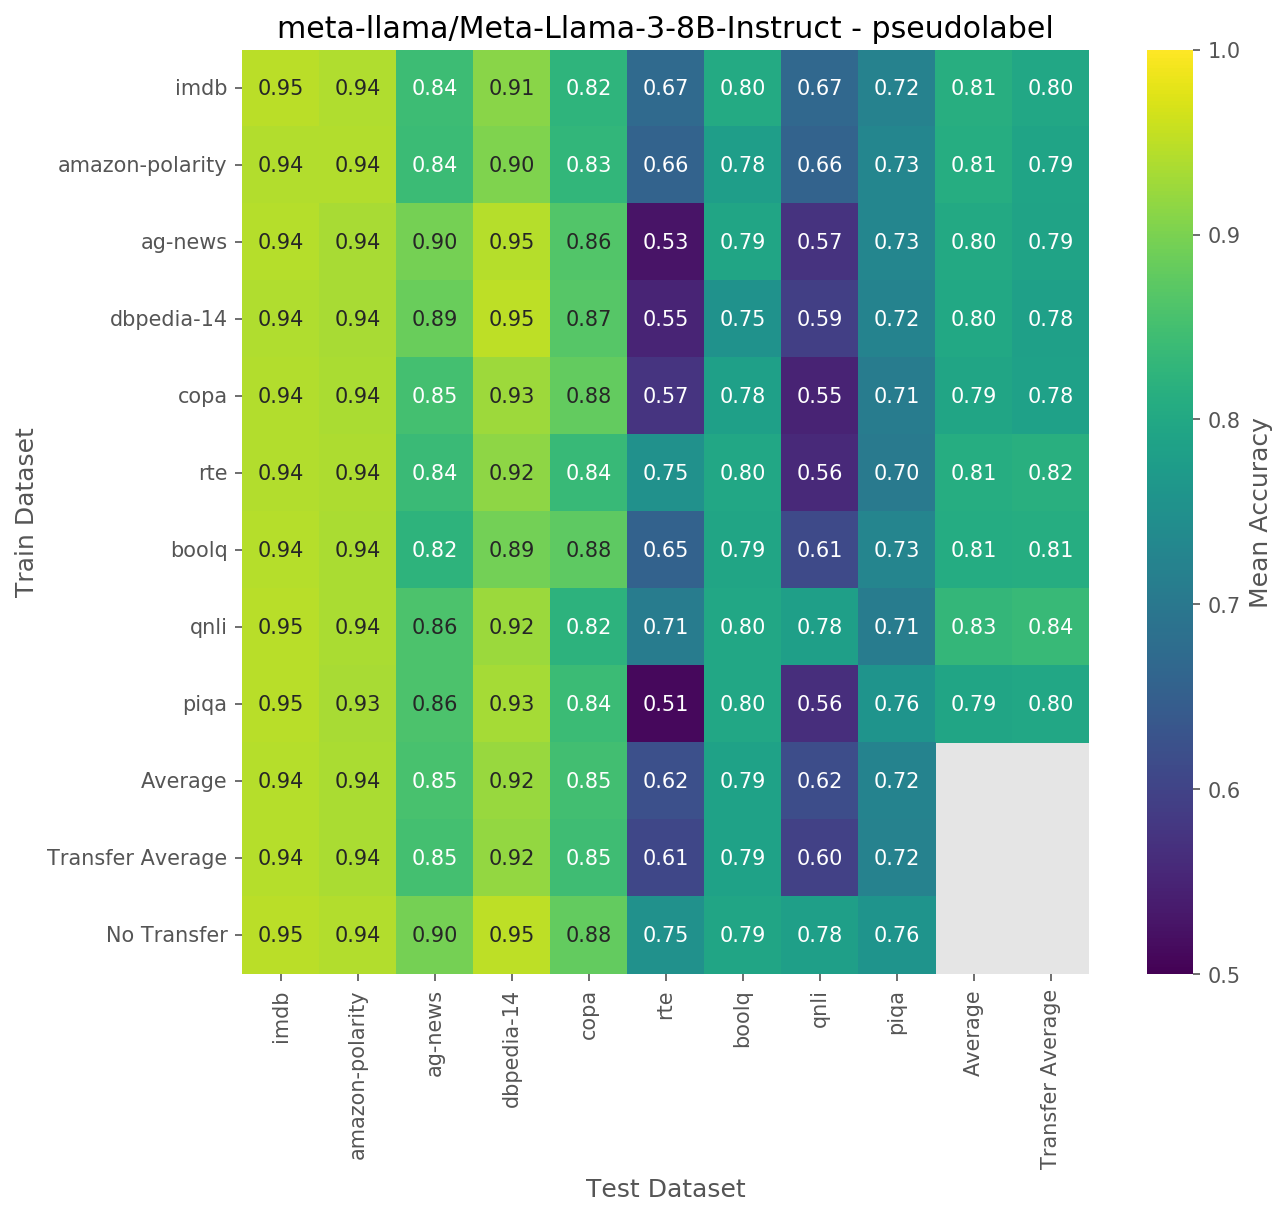

meta-llama/Meta-Llama-3-8B-Instruct/normal-bananashed/layer_-1/pseudolabel/rounds_5/select_high_confidence_consistency/prob_thres_0.7/label_argmax/ccs_lr/mode_concat/sup_weight_10/unsup_weight_1/lr_0.001/n_epochs_10000
meta-llama/Meta-Llama-3-8B-Instruct - pseudolabel
In-domain accuracy: 0.8601
OOD accuracy: 0.7762


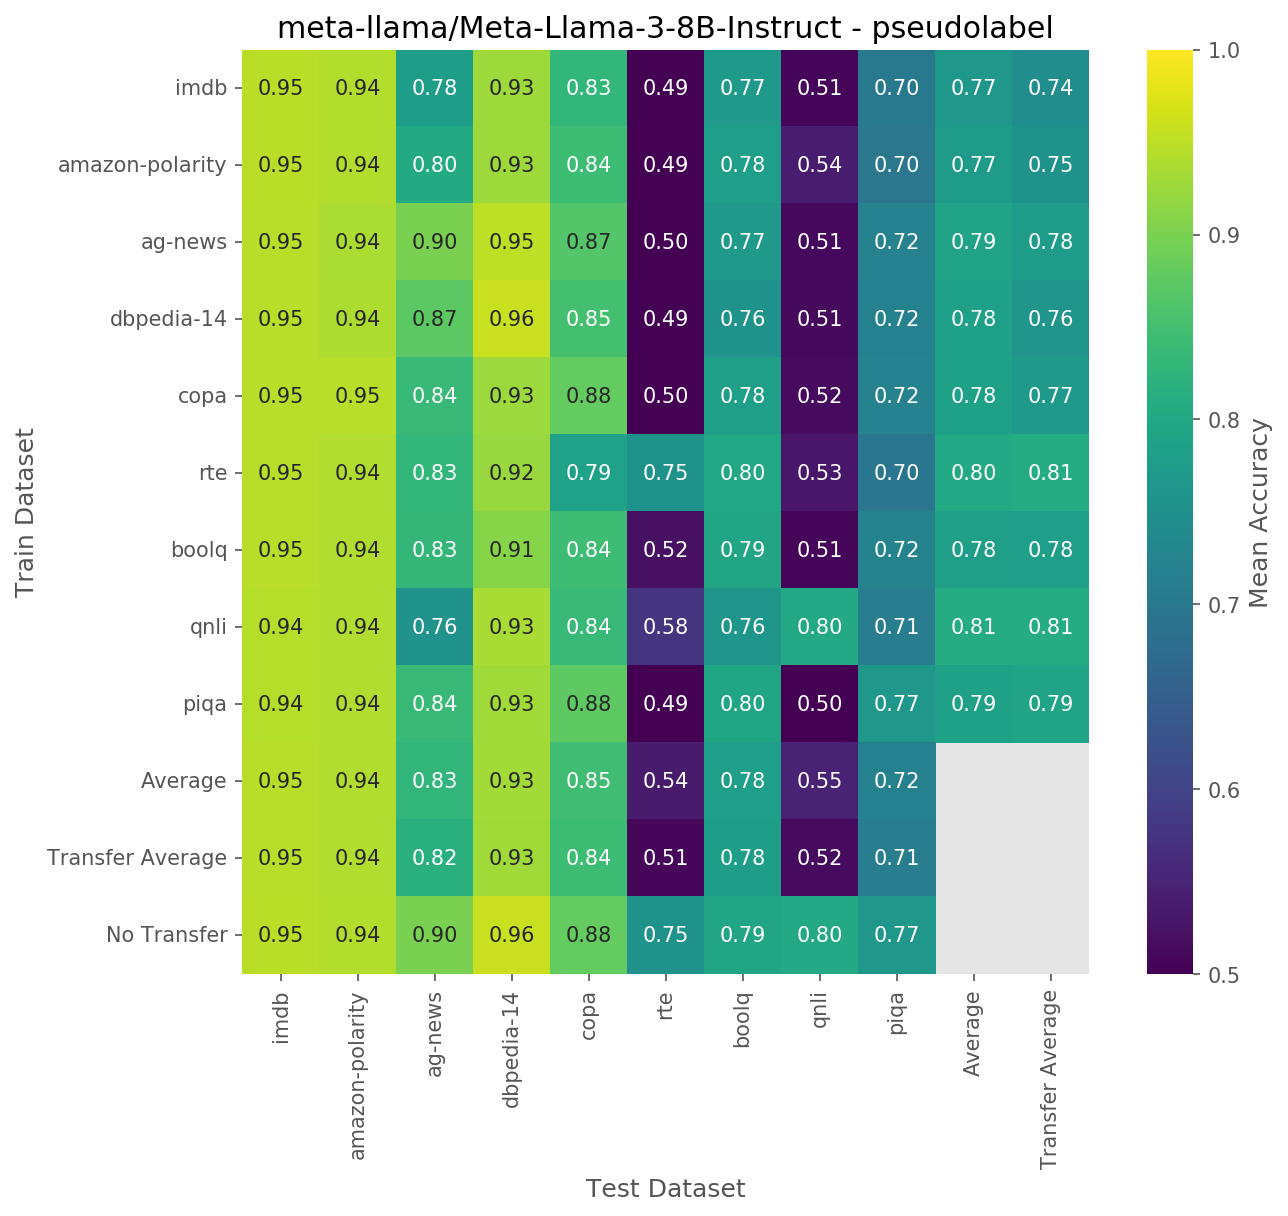

In [29]:
filter_train_equals_test = True
# If we accidentally evaluated CCS on multiple train_labeled columns per
# (train, test) pair, take the mean accuracy over the train_labeled column per
# pair, which should be identical (up to randomness in the training).
dedup_ccs_train_labeled_cols = True

for exp_name, df in experiment_dfs.items():
    print(exp_name)
    if filter_train_equals_test:
        df = filter_train_equals_test_per_method(
            df, is_ccs_lr_in_span_oracle=is_ccs_lr_in_span_oracle
        )

    if (
        df["method"].unique() == ["CCS+LR"]
        and reduce_ccs_lr_method(df) == "CCS"
        and dedup_ccs_train_labeled_cols
    ):
        df = compute_mean_train_test_acc_df_over_nonunique_cols(df)

    print_acc_stats_for_df(df)
    heatmap_kwargs = {"vmin": 0.5, "vmax": 1}
    plot_heatmap(df, "accuracy", std_annot=False, heatmap_kwargs=heatmap_kwargs)

## Layer sweep

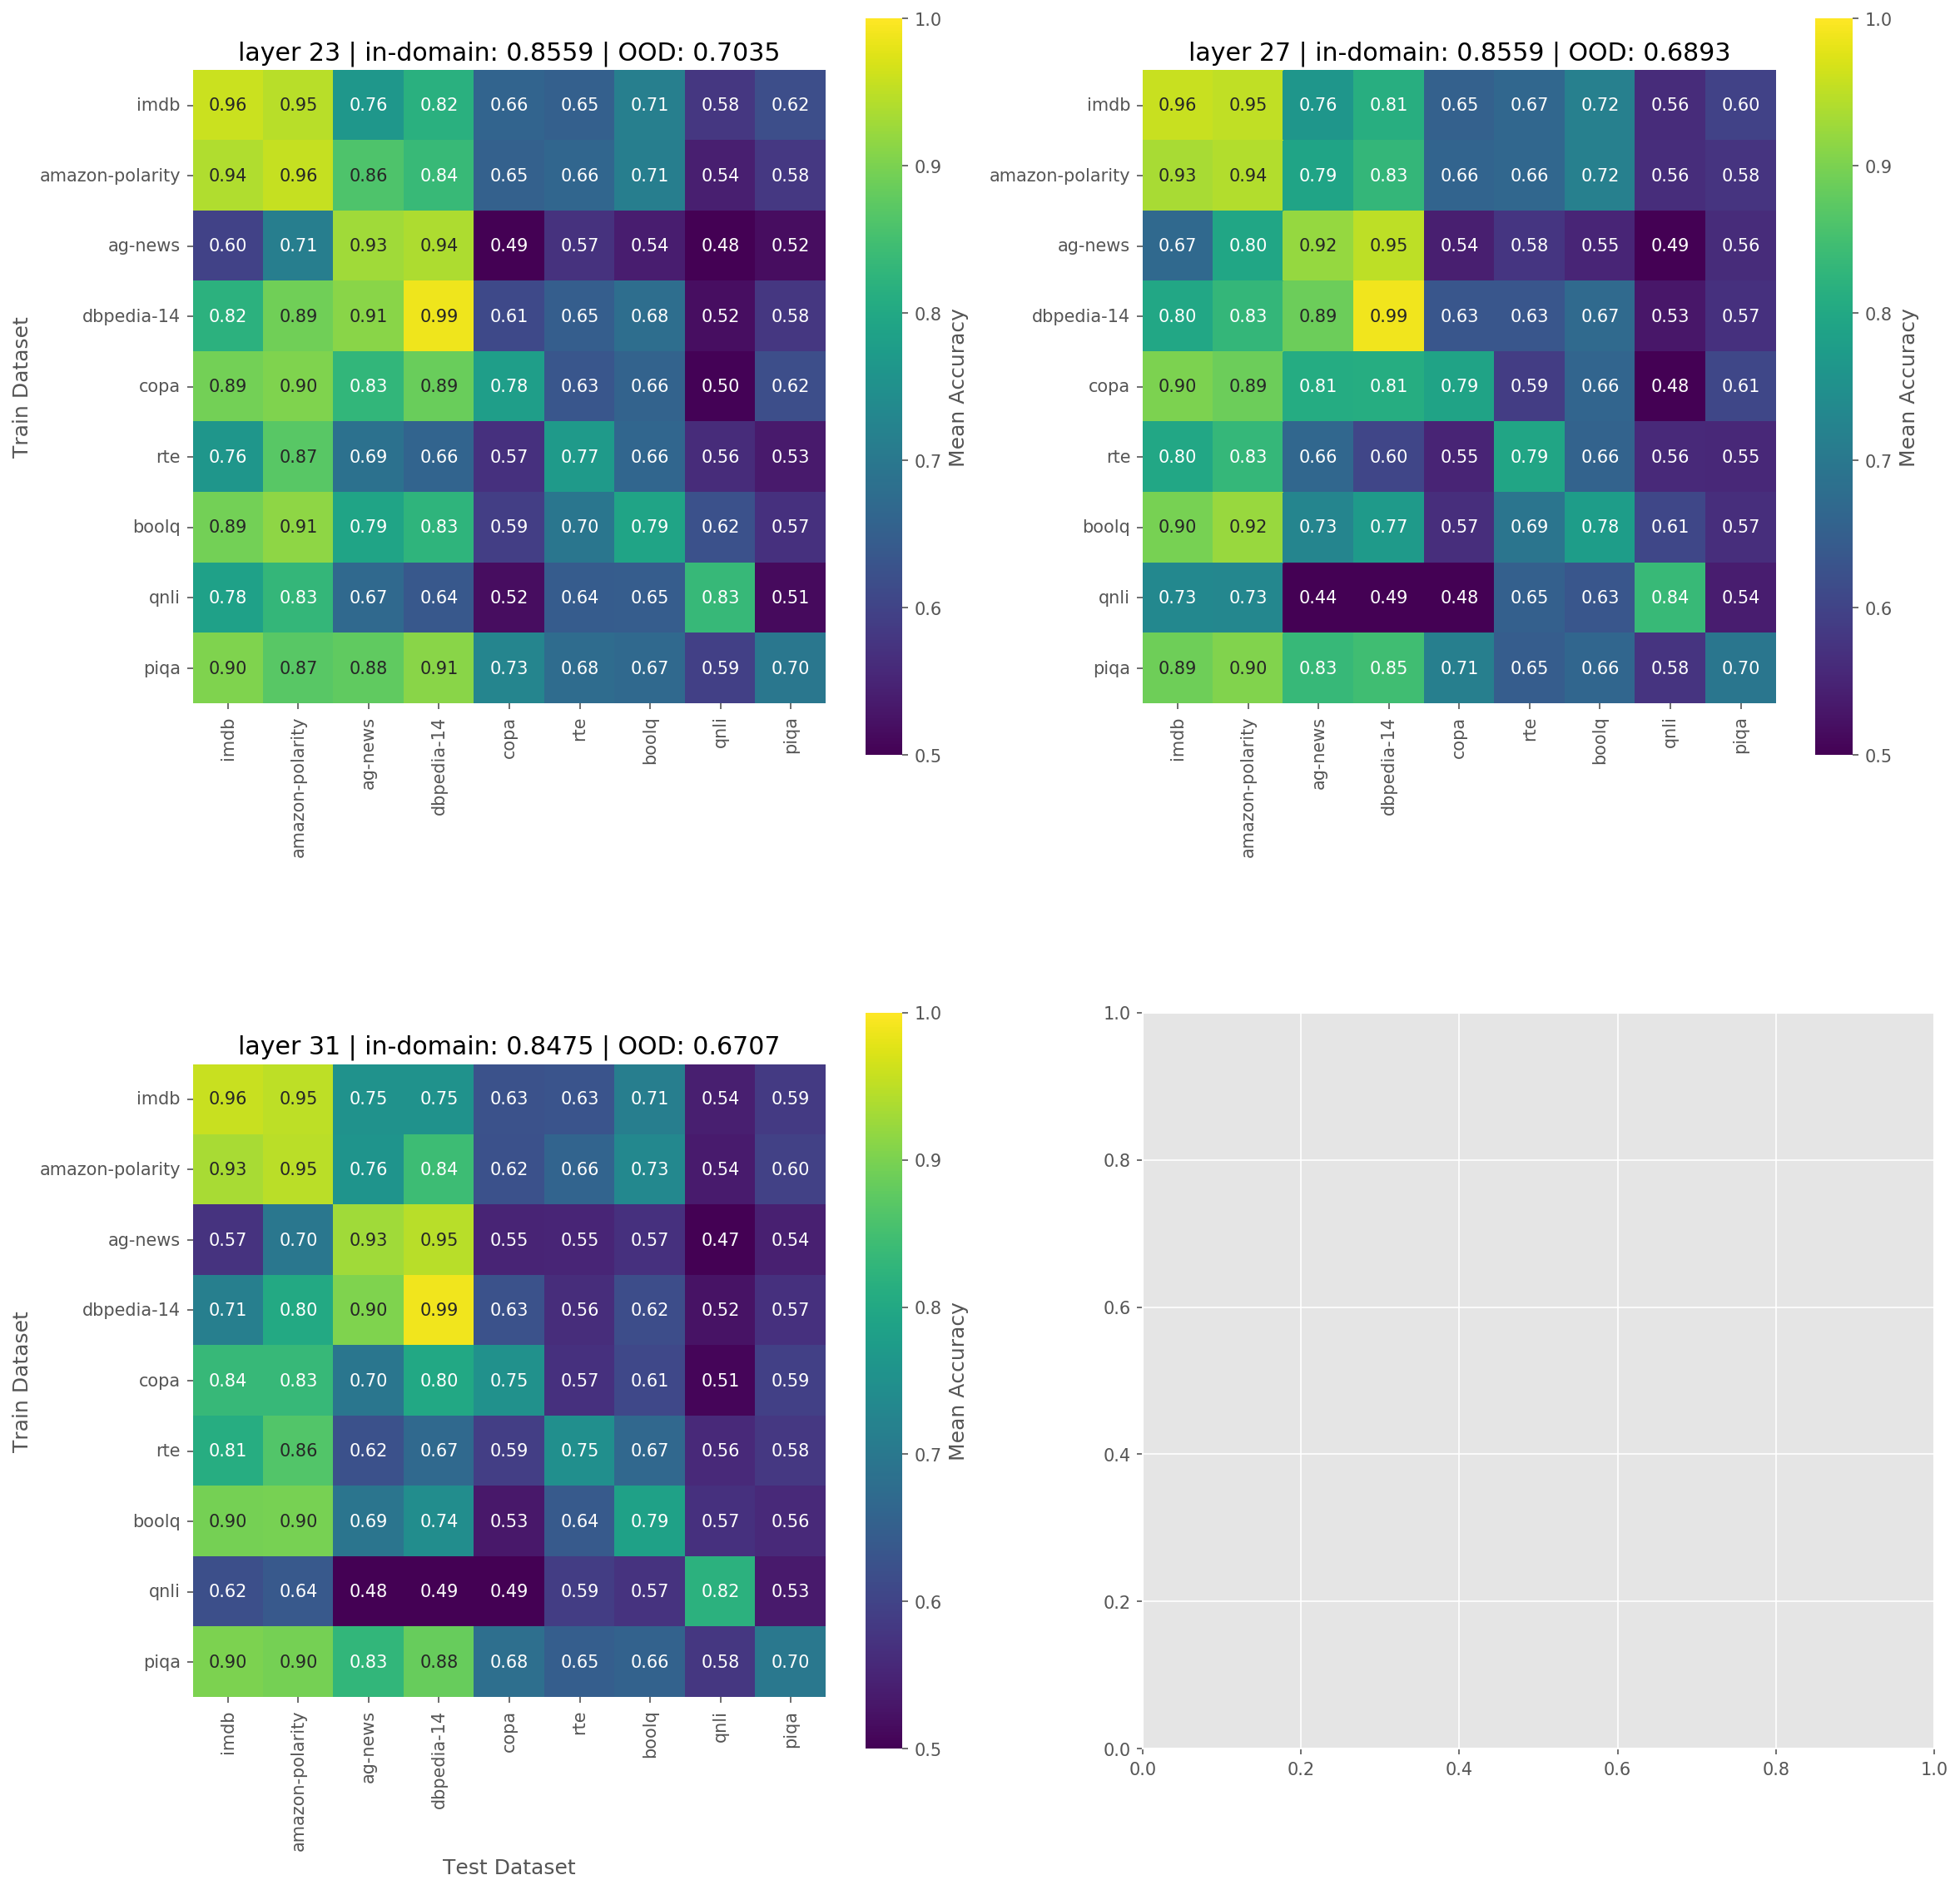

In [ ]:
# Plot multiple transfer accuracy heatmaps in the same figure.
layers = []
for p, df in experiment_dfs.items():
    layer = int(p.split("/layer_")[1].split("/")[0])
    if layer < 0:
        model = df["model"].unique()
        if len(model) > 1:
            raise ValueError(f"Multiple models found: {model}")
        num_hidden_layers = hf_utils.get_num_hidden_layers(
            model[0], use_auth_token=HF_AUTH_TOKEN
        )
        layer += num_hidden_layers
    layers.append(layer)

layers_exp_df_items = sorted(zip(layers, experiment_dfs.items()), key=lambda x: x[0])
dfs = [df for _, (_, df) in layers_exp_df_items]
titles = [f"layer {layer}" for layer, (_, df) in layers_exp_df_items]

filter_train_equals_test = True
# If we accidentally evaluated CCS on multiple train_labeled columns per
# (train, test) pair, take the mean accuracy over the train_labeled column per
# pair, which should be identical (up to randomness in the training).
dedup_ccs_train_labeled_cols = True

heatmap_subplots(dfs, titles)

# Compare accuracies

In [ ]:
exp_names_and_dfs = list(experiment_dfs.items())
exp1, df1 = exp_names_and_dfs[-1]
df1_method = df1.method.unique()
if len(df1_method) > 1:
    raise ValueError(f"Expected one unique method, got {df1_method}")
train_col1 = "train_labeled" if method_uses_labeled_and_unlabeled_data(df1) else "train"

for exp2, df2 in exp_names_and_dfs:
    df2_method = df2.method.unique()
    if len(df2_method) > 1:
        raise ValueError(f"Expected one unique method, got {df2_method}")

    train_col2 = (
        "train_labeled" if method_uses_labeled_and_unlabeled_data(df2) else "train"
    )
    comparison = compare_accuracies(
        df1,
        df2,
        train_col1,
        train_col2,
        is_ccs_lr_in_span_oracle=is_ccs_lr_in_span_oracle,
    )
    print(f"Comparison between {exp1} and {exp2}:")
    pprint.pprint(comparison)
    print()

# Accuracy violin plots

In [ ]:
for exp_name, df in experiment_dfs.items():
    print(exp_name)
    plot_violin(df)

# Training curves

In [36]:
path = "extraction_results/meta-llama/Meta-Llama-3-8B-Instruct/normal-bananashed/layer_-1/ccs_lr/mode_concat/sup_weight_10/unsup_weight_1/lr_0.0001/n_epochs_10000/meta-llama-Meta-Llama-3-8B-Instruct/nolabel_rte-label_amazon-polarity/seed_0/1/train/fit_result_CCS+LR.json"

with open(path, "r") as f:
    fit_result = json.load(f)

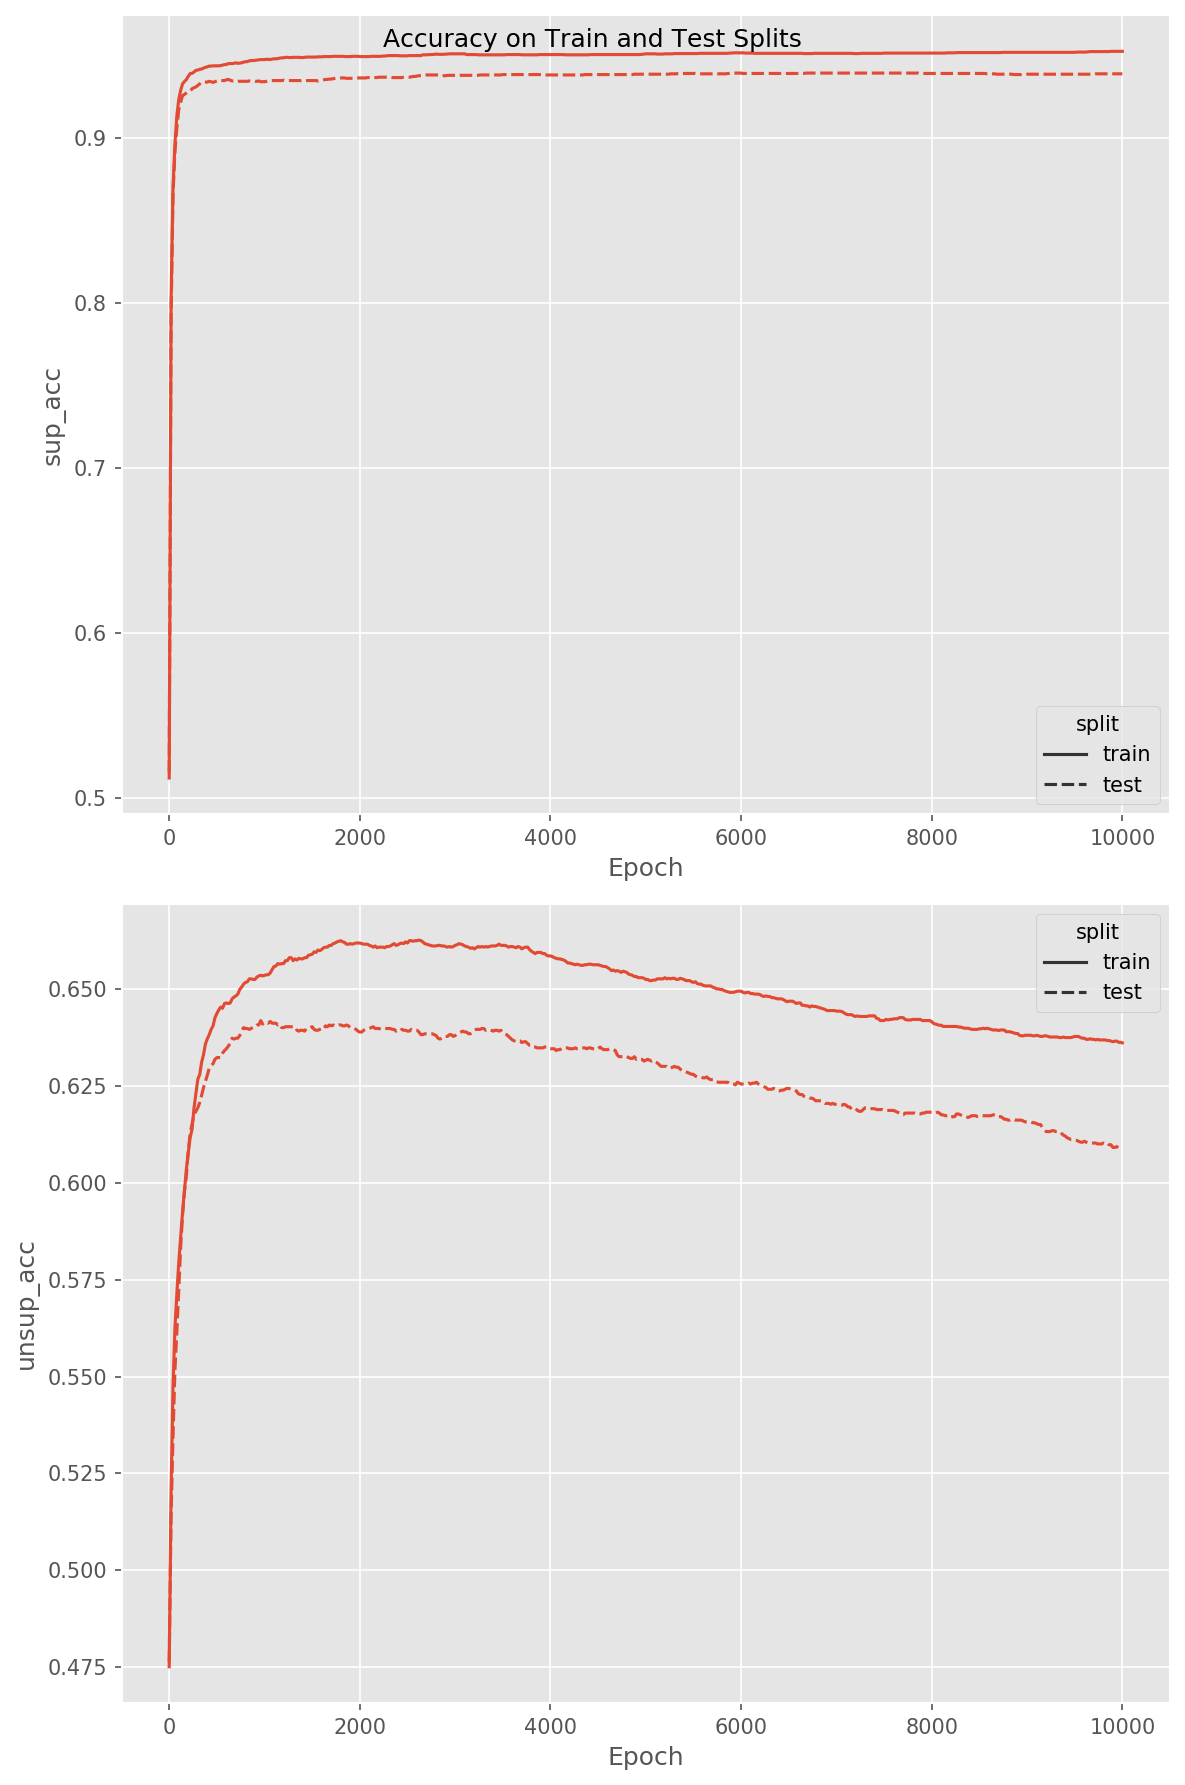

In [37]:
plot_df = plot_utils.plot_accuracy(fit_result)

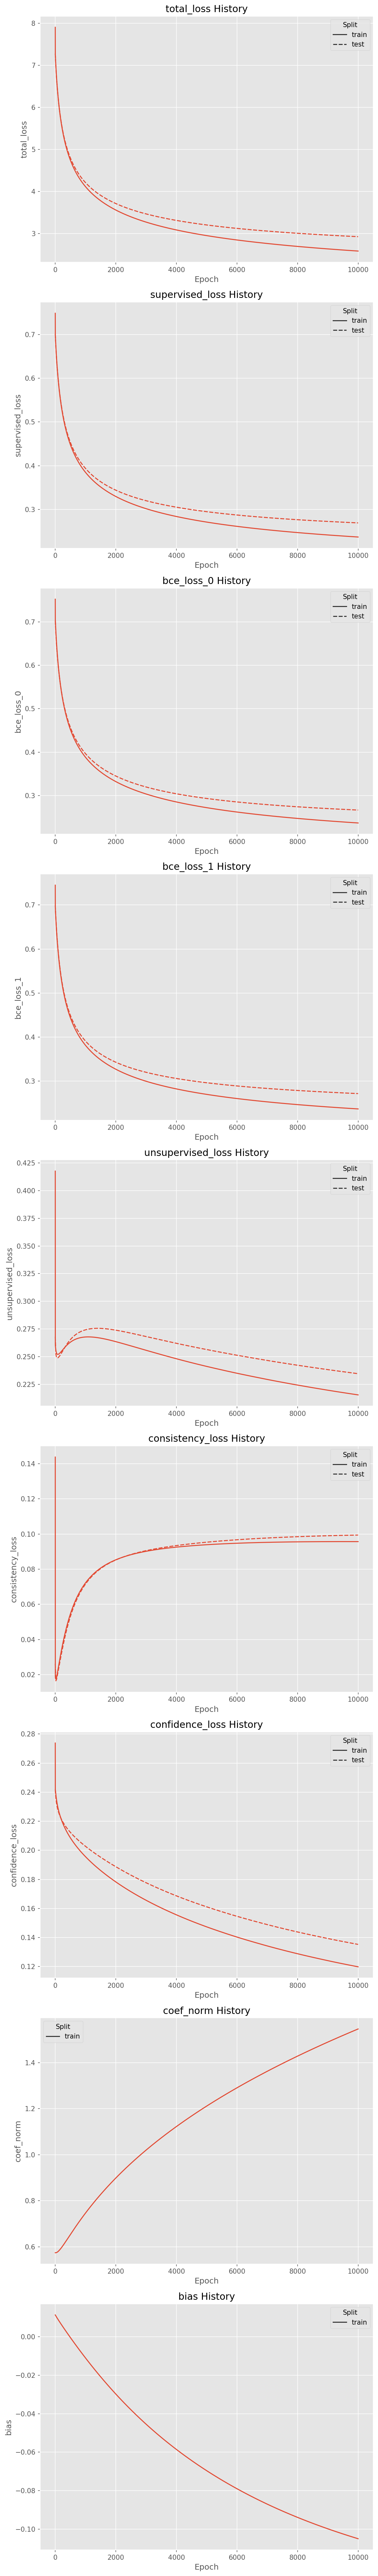

In [38]:
history_plot_df = plot_utils.plot_history(fit_result)

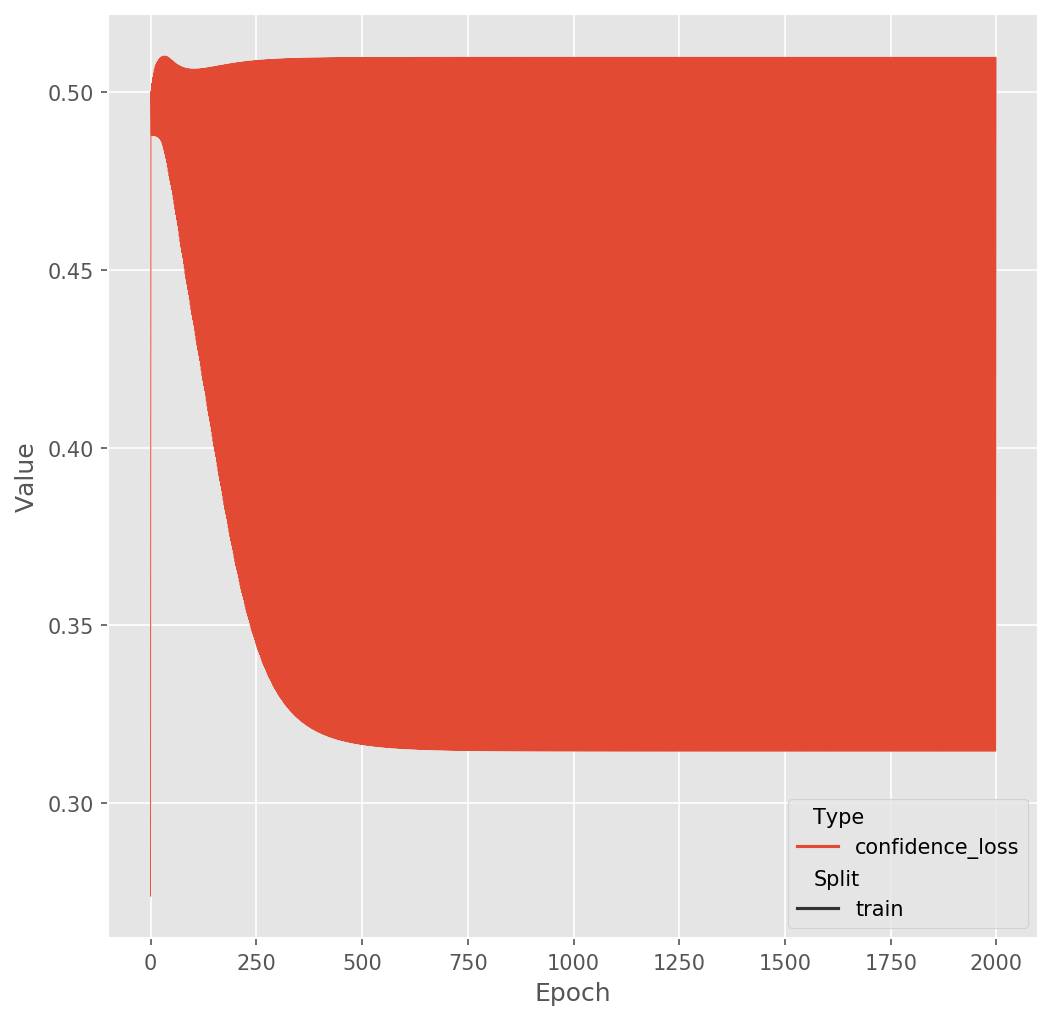

In [35]:
sns.lineplot(
    data=history_plot_df.query("Type == 'confidence_loss' and Split == 'train' and Epoch < 2000"),
    x="Epoch",
    y="Value",
    hue="Type",
    style="Split",
    ci="sd",
    linewidth=0.5,
)

# ECE

In [ ]:
min_ece = df.ece.min()
max_ece = df.ece.max()
heatmap_kwargs = {"vmin": min_ece, "vmax": max_ece}
plot_heatmap(df, "ece", std_annot=False, heatmap_kwargs=heatmap_kwargs)

# Calibration curves

In [ ]:
save_dir = "extraction_results"
experiment_name = "Llama-2-7b-chat-hf_v3"
ece_df = make_ece_df(save_dir, experiment_name)

In [ ]:
ece_df

In [ ]:
sample_ece_df = ece_df.query(
    "method == 'CCS' and train == test and seed == 1 and prompt == 0"
)
for key, group_df in sample_ece_df.groupby(
    ["model", "method", "train", "test", "prompt", "seed"]
):
    assert len(group_df) == 2
    og_row = group_df[~group_df["flip_probs"]].iloc[0]
    flip_row = group_df[group_df["flip_probs"]].iloc[0]

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    og_title = f"ECE={og_row.ece:.4f}"
    calibration_plot_from_bin_xy(
        og_row.bin_mean_probs, og_row.bin_mean_labels, og_title, ax=ax[0]
    )

    flip_title = f"ECE={flip_row.ece:.4f}"
    calibration_plot_from_bin_xy(
        flip_row.bin_mean_probs, flip_row.bin_mean_labels, flip_title, ax=ax[1]
    )

    title = f"{og_row.model} - {og_row.method} - train={og_row.train} - test={og_row.test} - prompt={og_row.prompt} - seed={og_row.seed}"
    fig.suptitle(title)

# LR direction similarity

In [ ]:
# Compute inner products of all pairwise orthogonal directions across all
# datasets.

exp_dir = Path(
    "/nas/ucb/ebronstein/Exhaustive-CCS/extraction_results/Llama-2-7b-chat-hf_normal-bananashed_CCS-in-LR-span-convex_20_orth_dirs/meta-llama-Llama-2-7b-chat-hf"
)
# Arbitrarily use IMDB as the unlabeled/unsupervised dataset to be consistent
# and because we only want to change the labeled dataset, which is used to
# train the orthogonal LR directions. Probably due to randomness, the LR
# directions are not the same across different unlabeled datasets for a given
# labeled dataset.
paths = exp_dir.glob("nolabel_imdb*/**/orthogonal_directions.npy")
inner_prods_df = make_inner_prods_df(paths)

## First direction only

In [ ]:
plot_inner_prods_heatmap(inner_prods_df.query("dir1_idx == dir2_idx == 0"))

## Most similar directions for each dataset pair

In [ ]:
# Get the most similar directions by taking the max of the inner products for
# each dataset pair.
max_inner_prods_per_ds_combo_df = (
    inner_prods_df.groupby(["ds1", "ds2"])
    .inner_prod.max()
    .unstack()
    .reindex(index=DATASET_ORDER, columns=DATASET_ORDER)
)
plot_inner_prods_heatmap(max_inner_prods_per_ds_combo_df, needs_pivot=False)

## Top similar directions for each dataset pair

In [ ]:
for ds1, ds2 in itertools.combinations(DATASET_ORDER, r=2):
    display(
        inner_prods_df.query("ds1 == @ds1 and ds2 == @ds2")
        .sort_values("inner_prod", ascending=False)
        .head(5)
    )

## Similarity of random vectors

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

dims = list(range(1, 1000, 100))
matrices = [np.random.normal(size=(1000, N)) for N in dims]
res = [np.abs(cosine_similarity(matrix, matrix)).mean() for matrix in matrices]
plt.plot(dims, res)

In [ ]:
vecs = np.random.normal(size=(10000, 4096))
similarities = cosine_similarity(vecs, vecs)
mean_abs_sim = np.abs(similarities).mean()
mean_abs_sim

# LR in span analysis

In [ ]:
# Compute inner products of all pairwise orthogonal directions across all
# datasets.

exp_dir = Path(
    "/nas/ucb/ebronstein/Exhaustive-CCS/extraction_results/Llama-2-7b-chat-hf_normal-bananashed_CCS-in-LR-span-convex_20_orth_dirs/meta-llama-Llama-2-7b-chat-hf"
)
# Arbitrarily use IMDB as the unlabeled/unsupervised dataset to be consistent
# and because we only want to change the labeled dataset, which is used to
# train the orthogonal LR directions. Probably due to randomness, the LR
# directions are not the same across different unlabeled datasets for a given
# labeled dataset.
paths = exp_dir.glob("nolabel_imdb*/**/orthogonal_directions.npy")
train_to_orth_dirs = get_train_to_orth_dirs_dict(paths)

In [ ]:
orth_dirs_1 = train_to_orth_dirs["imdb"]
orth_dirs_2 = train_to_orth_dirs["amazon-polarity"]

rows = []
for ds1, ds2 in itertools.product(train_to_orth_dirs, repeat=2):
    orth_dirs_1 = train_to_orth_dirs[ds1]
    orth_dirs_2 = train_to_orth_dirs[ds2]

    # Project each direction in orth_dirs_1 onto each direction in orth_dirs_2.
    # inner_prods[i, j] is the inner product of the i-th direction in orth_dirs_1
    # with the j-th direction in orth_dirs_2.
    inner_prods = orth_dirs_1 @ orth_dirs_2.T

    # orth_dirs_1 projected onto orth_dirs_2. dirs_1_proj_dirs2[i] is the i-th
    # direction from orth_dirs_1 projected onto the span of the rows of orth_dirs_2.
    dirs_1_proj_dirs_2 = orth_dirs_1 @ orth_dirs_2.T @ orth_dirs_2  # [n_dirs, hidden_dim]

    # Fraction (norm-wise) that each direction in orth_dirs_1 is in the span of the
    # directions in orth_dirs_2. Shape: [n_dirs].
    # NOTE: the division by the norm of each orthogonal direction should not be
    # necessary since the orthogonal directions should be normalized.
    frac_dirs_1_in_span_dirs_2 = np.linalg.norm(dirs_1_proj_dirs_2, axis=1) / np.linalg.norm(
        orth_dirs_1, axis=1
    )
    for i in range(frac_dirs_1_in_span_dirs_2.shape[0]):
        rows.append({
            "ds1": ds1,
            "ds2": ds2,
            "dir1_idx": i,
            "frac_in_span": frac_dirs_1_in_span_dirs_2[i],
        })

frac_in_span_df = pd.DataFrame(rows)

In [ ]:
frac_in_span_df.query("dir1_idx == 0").pivot(
    index="ds1", columns="ds2", values="frac_in_span"
).reindex(index=DATASET_ORDER, columns=DATASET_ORDER)

## First direction only

In [ ]:
plot_heatmap_from_df(
    frac_in_span_df.query("dir1_idx == 0"),
    needs_pivot=True,
    pivot_values="frac_in_span",
    cbar_label="Fraction in Span",
    title="Frac. Set 2's Best LR Direction in Span of Set 1's LR Directions",
)

## Most in-span direction

In [ ]:
max_frac_in_span_per_ds_combo_df = (
    frac_in_span_df.groupby(["ds1", "ds2"])["frac_in_span"]
    .max()
    .unstack()
    .reindex(index=DATASET_ORDER, columns=DATASET_ORDER)
)
plot_heatmap_from_df(
    max_frac_in_span_per_ds_combo_df,
    needs_pivot=False,
    cbar_label="Max Frac. in Span",
    title="Max Frac. Set 2's LR Directions in Span of Set 1's LR Directions",
)

## Top in-span direction for each dataset combo

In [ ]:
for ds1, ds2 in itertools.combinations(DATASET_ORDER, r=2):
    display(
        frac_in_span_df.query("ds1 == @ds1 and ds2 == @ds2")
        .sort_values("frac_in_span", ascending=False)
        .head(5)
    )

## In-span-ness of random vectors

In [ ]:
def gs(X, row_vecs=True, norm=True):
    """Gram-Schmidt process for orthonormalizing a set of vectors."""
    if not row_vecs:
        X = X.T
    Y = X[0:1, :].copy()
    for i in range(1, X.shape[0]):
        proj = np.diag((X[i, :].dot(Y.T) / np.linalg.norm(Y, axis=1) ** 2).flat).dot(Y)
        Y = np.vstack((Y, X[i, :] - proj.sum(0)))
    if norm:
        Y = np.diag(1 / np.linalg.norm(Y, axis=1)).dot(Y)
    if row_vecs:
        return Y
    else:
        return Y.T

In [ ]:
dirs_1 = np.random.normal(size=(100, 20, 4096))
dirs_2 = np.random.normal(size=(100, 20, 4096))

# Normalize the directions
dirs_1 = dirs_1 / np.linalg.norm(dirs_1, axis=-1, keepdims=True)
dirs_2 = dirs_2 / np.linalg.norm(dirs_2, axis=-1, keepdims=True)

# Make an orthonormal basis for the span of the rows of each matrix
orth_dirs_1 = np.stack([gs(x) for x in dirs_1])
orth_dirs_2 = np.stack([gs(x) for x in dirs_2])

inner_prods = orth_dirs_1 @ orth_dirs_2.transpose(0, 2, 1)

# orth_dirs_1 projected onto orth_dirs_2. dirs_1_proj_dirs2[i] is the i-th
# direction from orth_dirs_1 projected onto the span of the rows of orth_dirs_2.
dirs_1_proj_dirs_2 = (
    orth_dirs_1 @ orth_dirs_2.transpose(0, 2, 1) @ orth_dirs_2
)  # [n_dirs, hidden_dim]

# Fraction (norm-wise) that each direction in orth_dirs_1 is in the span of the
# directions in orth_dirs_2. Shape: [n_dirs].
frac_dirs_1_in_span_dirs_2 = np.linalg.norm(dirs_1_proj_dirs_2, axis=-1)

frac_dirs_1_in_span_dirs_2.max(axis=-1).mean()

In [ ]:
frac_dirs_1_in_span_dirs_2.max(axis=-1).std()

# Oracle LR in LR span

## Transfer accuracy

In [ ]:
def get_orthogonal_directions_dataset(load_orthogonal_directions_dir: str) -> str:
    """Return the dataset for which the orthogonal directions were computed."""
    combined_datasets_str = os.path.basename(
        os.path.normpath(load_orthogonal_directions_dir)
    )
    return parse_combined_datasets(combined_datasets_str)[1]


df = experiment_dfs[
    "Llama-2-7b-chat-hf_normal-bananashed_oracle-LR-in-LR-span-convex_4_orth_dirs"
]

df = df[df["train"] == df["train_labeled"]]
df = df[df["train"] == df["test"]]
df = df.copy()
df["train"] = df.load_orthogonal_directions_dir.apply(get_orthogonal_directions_dataset)
df["train_labeled"] = df["train"]

heatmap_kwargs = {"vmin": 0.5, "vmax": 1}
plot_heatmap(df, "accuracy", std_annot=False, heatmap_kwargs=heatmap_kwargs)

## Span weights

In [ ]:
exp_dir = Path("/nas/ucb/ebronstein/Exhaustive-CCS/extraction_results/Llama-2-7b-chat-hf_normal-bananashed_oracle-LR-in-LR-span-convex_15_orth_dirs/meta-llama-Llama-2-7b-chat-hf")

paths = exp_dir.glob("**/coef.npy")
rows = []
for path in paths:
    coef = np.load(path).squeeze(0)
    weights = np.exp(coef)
    weights /= weights.sum()

    with open(Path(*path.parts[:-3]) / "config.json", "r") as f:
        config = json.load(f)

    train_ds = config["labeled_datasets"]
    test_ds = parse_combined_datasets(Path(config["load_orthogonal_directions_dir"]).name)[1]

    rows.append({
        "train": train_ds,
        "test": test_ds,
        "weights": weights,
    })

weights_df = pd.DataFrame(rows)

In [ ]:
df_long = weights_df.explode("weights")
df_long["weights"] = df_long["weights"].astype(float)
df_long["weight_id"] = df_long.groupby(["train", "test"]).cumcount()

In [ ]:
# Setting up the FacetGrid
g = sns.FacetGrid(
    df_long,
    row="train",
    col="test",
    row_order=DATASET_ORDER,
    col_order=DATASET_ORDER,
    margin_titles=True,
    sharey=False,
)

# Mapping the function to the grid
g.map(plt.hist, "weights")
plt.show()

In [ ]:
def debug_stacked_bar(data, **kwargs):
    print(data.train.unique(), data.test.unique())

g.map_dataframe(debug_stacked_bar)

# Oracle LR in CCS span

In [ ]:
def get_unsup_orthogonal_directions_dataset(load_orthogonal_directions_dir: str) -> str:
    """Return the dataset for which the unsupervised orthogonal directions were computed."""
    combined_datasets_str = os.path.basename(
        os.path.normpath(load_orthogonal_directions_dir)
    )
    return parse_combined_datasets(combined_datasets_str)[0]


# Setup: train = train_labeled = test is when we trained an oracle LR using the
# labeled test set. The actual "train" is the dataset we used to compute the
# orthogonal CCS directions, which we extraction from the
# load_orthogonal_directions_dir.

for experiment_name in [
    # "Llama-2-7b-chat-hf_normal-bananashed_LR-in-CCS-span-convex_1_orth_dirs-v2",
    # "Llama-2-7b-chat-hf_normal-bananashed_LR-in-CCS-span-convex_2_orth_dirs-v2",
    # "Llama-2-7b-chat-hf_normal-bananashed_LR-in-CCS-span-convex_4_orth_dirs-v2",
    # "Llama-2-7b-chat-hf_normal-bananashed_LR-in-CCS-span-convex_8_orth_dirs-v2",
    # "Llama-2-7b-chat-hf_normal-bananashed_LR-in-CCS-span-convex_15_orth_dirs-v2",
    "Llama-2-7b-chat-hf_normal-bananashed_LR-in-CCS-span-convex_20_orth_dirs",
    "Llama-2-7b-chat-hf_normal-bananashed_LR-in-CCS-span-convex_100_orth_dirs",
]:
    print(experiment_name)
    df = experiment_dfs[experiment_name]

    # Since the unlabeled training datasets were not used to train the oracle LR,
    # we set train and train_labeled to be the same. Assert that this is the case.
    assert df["train"].equals(df["train_labeled"])
    # Dataset that was used to get the CCS orthogonal directions.
    df["orth_dirs_ds"] = df.load_orthogonal_directions_dir.apply(
        get_unsup_orthogonal_directions_dataset
    )

    # Filter train == test since we're using an oracle LR.
    df = df.query("train == test")
    df = df.copy()
    # Set the "train" dataset to be the dataset for which the
    # orthogonal directions were computed so that we can reuse the
    # plot_heatmap function, which by default plots train vs. test.
    df["train"] = df["orth_dirs_ds"]
    df["train_labeled"] = df["orth_dirs_ds"]

    num_orth_dirs = df.num_orthogonal_directions.unique()
    if len(num_orth_dirs) > 1:
        raise ValueError(
            f"Expected one unique num_orthogonal_directions, got {num_orth_dirs}"
        )
    num_orth_dirs = num_orth_dirs[0]

    heatmap_kwargs = {"vmin": 0.0, "vmax": 1}
    plot_heatmap(
        df,
        "accuracy",
        std_annot=False,
        heatmap_kwargs=heatmap_kwargs,
        xlabel="Train/Test Dataset",
        ylabel="Orthogonal Directions Dataset",
        title=f"Llama-2-7b-chat-hf - Oracle LR in CCS Span ({num_orth_dirs}) - Mean Acc.",
    )

# LR in CCS span

## Transfer accuracy

### V0

In [ ]:
def get_unsup_orthogonal_directions_dataset(load_orthogonal_directions_dir: str) -> str:
    """Return the dataset for which the unsupervised orthogonal directions were computed."""
    combined_datasets_str = os.path.basename(
        os.path.normpath(load_orthogonal_directions_dir)
    )
    return parse_combined_datasets(combined_datasets_str)[0]


# Setup: train = train_labeled = test is when we trained an oracle LR using the
# labeled test set. The actual "train" is the dataset we used to compute the
# orthogonal CCS directions, which we extraction from the
# load_orthogonal_directions_dir.

for experiment_name in [
    "Llama-2-7b-chat-hf_normal-bananashed_LR-in-CCS-span-convex_1_orth_dirs-v2",
    "Llama-2-7b-chat-hf_normal-bananashed_LR-in-CCS-span-convex_2_orth_dirs-v2",
    "Llama-2-7b-chat-hf_normal-bananashed_LR-in-CCS-span-convex_4_orth_dirs-v2",
    "Llama-2-7b-chat-hf_normal-bananashed_LR-in-CCS-span-convex_8_orth_dirs-v2",
    "Llama-2-7b-chat-hf_normal-bananashed_LR-in-CCS-span-convex_15_orth_dirs-v2",
    "Llama-2-7b-chat-hf_normal-bananashed_LR-in-CCS-span-convex_20_orth_dirs",
    "Llama-2-7b-chat-hf_normal-bananashed_LR-in-CCS-span-convex_100_orth_dirs",
]:
    print(experiment_name)
    df = experiment_dfs[experiment_name]

    # Since the unlabeled training datasets were not used to train the oracle LR,
    # we set train and train_labeled to be the same. Assert that this is the case.
    assert df["train"].equals(df["train_labeled"])
    # Dataset that was used to get the CCS orthogonal directions.
    df["orth_dirs_ds"] = df.load_orthogonal_directions_dir.apply(
        get_unsup_orthogonal_directions_dataset
    )
    # Filter the DataFrame where the test dataset is the same as the dataset for
    # which the orthogonal directions were computed.
    df = df[df["test"] == df["orth_dirs_ds"]]

    num_orth_dirs = df.num_orthogonal_directions.unique()
    if len(num_orth_dirs) > 1:
        raise ValueError(
            f"Expected one unique num_orthogonal_directions, got {num_orth_dirs}"
        )
    num_orth_dirs = num_orth_dirs[0]

    heatmap_kwargs = {"vmin": 0.0, "vmax": 1}
    plot_heatmap(
        df,
        "accuracy",
        std_annot=False,
        heatmap_kwargs=heatmap_kwargs,
        xlabel="Test (Orthogonal Directions) Dataset",
        ylabel="Train Dataset",
        title=f"Llama-2-7b-chat-hf - LR in CCS Span ({num_orth_dirs}) - Mean Acc.",
    )

### V1

In [ ]:
# Example filters (set to None if you don't want to filter by these)
model_filter = None
train_set_filter = None
eval_set_filter = None
use_latest_run_id = True
use_best_in_domain_acc = True
is_ccs_lr_in_span_oracle = False

experiment_dfs = load_eval_csvs(
    "extraction_results/mistralai/Mistral-7B-Instruct-v0.2/normal/layer_-1/ccs_lr_in_span/mode_concat/sup_weight_1/unsup_weight_0/lr_0.01/n_epochs_5000",
    pattern=None,
    model_filter=model_filter,
    train_set_filter=train_set_filter,
    eval_set_filter=eval_set_filter,
    use_latest_run_id=use_latest_run_id,
    use_best_in_domain_acc=use_best_in_domain_acc,
    is_ccs_lr_in_span_oracle=is_ccs_lr_in_span_oracle,
)

# Exclude df with 100 orthogonal directions because that was just used to make
# the span dirs.
experiment_dfs = {
    key: df for key, df in experiment_dfs.items() if "n_orth_dirs_100" not in key
}
experiment_dfs = {
    key: get_lr_in_ccs_span_transfer_df(df) for key, df in experiment_dfs.items()
}

In [ ]:
def get_unsup_orthogonal_directions_dataset(load_orthogonal_directions_dir: str) -> str:
    """Return the dataset for which the unsupervised orthogonal directions were computed."""
    combined_datasets_str = os.path.basename(
        os.path.normpath(load_orthogonal_directions_dir)
    )
    return parse_combined_datasets(combined_datasets_str)[0]


def get_lr_in_ccs_span_transfer_df(df):
    # Since the unlabeled training datasets were not used to train the oracle LR,
    # we set train and train_labeled to be the same. Assert that this is the case.
    assert df["train"].equals(df["train_labeled"])
    # Dataset that was used to get the CCS orthogonal directions.
    df["orth_dirs_ds"] = df.load_orthogonal_directions_dir.apply(
        get_unsup_orthogonal_directions_dataset
    )
    # Filter the DataFrame where the test dataset is the same as the dataset for
    # which the orthogonal directions were computed.
    df = df[df["test"] == df["orth_dirs_ds"]]

    num_orth_dirs = df.num_orthogonal_directions.unique()
    if len(num_orth_dirs) > 1:
        raise ValueError(
            f"Expected one unique num_orthogonal_directions, got {num_orth_dirs}"
        )

    return df


num_orth_dirs_list = []
for p, df in experiment_dfs.items():
    num_orth_dirs = int(p.split("/n_orth_dirs_")[1].split("/")[0])
    num_orth_dirs_list.append(num_orth_dirs)

num_orth_dirs_exp_df_items = sorted(
    zip(num_orth_dirs_list, experiment_dfs.items()), key=lambda x: x[0]
)
dfs = [df for _, (_, df) in num_orth_dirs_exp_df_items]
titles = [
    f"num_orth_dirs {num_orth_dirs}"
    for num_orth_dirs, (_, df) in num_orth_dirs_exp_df_items
]

print("Experiments:")
for _, (path, _) in num_orth_dirs_exp_df_items:
    print(path)

filter_train_equals_test = False
# If we accidentally evaluated CCS on multiple train_labeled columns per
# (train, test) pair, take the mean accuracy over the train_labeled column per
# pair, which should be identical (up to randomness in the training).
dedup_ccs_train_labeled_cols = True

heatmap_subplots(
    dfs,
    titles,
    filter_train_equals_test=filter_train_equals_test,
    dedup_ccs_train_labeled_cols=dedup_ccs_train_labeled_cols,
)

In [ ]:
# Spot check the transfer accuracy.
df = dfs[0].query("train_labeled == 'imdb'")
rows = []
for key, group_df in df.groupby(["train", "train_labeled", "orth_dirs_ds", "test"]):
    accuracy = group_df["accuracy"].mean()
    load_orthogonal_directions_dir = group_df["load_orthogonal_directions_dir"].unique()
    assert len(load_orthogonal_directions_dir) == 1
    load_orthogonal_directions_dir = load_orthogonal_directions_dir[0]
    rows.append(
        {
            "train": key[0],
            "train_labeled": key[1],
            "orth_dirs_ds": key[2],
            "load_orthogonal_directions_dir": load_orthogonal_directions_dir,
            "test": key[3],
            "accuracy": accuracy,
        }
    )
df = pd.DataFrame(rows)

In [ ]:
# Make sure the orth_dirs_ds is correct based on the directory orth dirs are
# loaded from.
for i in range(len(df)):
    print(df.iloc[i].load_orthogonal_directions_dir, df.iloc[i].orth_dirs_ds)

## Span weights

In [ ]:
exp_dir = Path("/nas/ucb/ebronstein/Exhaustive-CCS/extraction_results/Llama-2-7b-chat-hf_normal-bananashed_LR-in-CCS-span-convex_20_orth_dirs-v2")

paths = exp_dir.glob("**/coef.npy")
rows = []
for path in paths:
    coef = np.load(path).squeeze(0)
    weights = np.exp(coef)
    weights /= weights.sum()

    with open(Path(*path.parts[:-3]) / "config.json", "r") as f:
        config = json.load(f)

    train_ds = config["datasets"]
    test_ds = parse_combined_datasets(Path(config["load_orthogonal_directions_dir"]).name)[0]

    rows.append({
        "train": train_ds,
        "test": test_ds,
        "weights": weights,
    })

weights_df = pd.DataFrame(rows)

In [ ]:
df_long = weights_df.explode("weights")
df_long["weights"] = df_long["weights"].astype(float)
df_long["weight_id"] = df_long.groupby(["train", "test"]).cumcount()

# Setting up the FacetGrid
g = sns.FacetGrid(
    df_long,
    row="train",
    col="test",
    row_order=DATASET_ORDER,
    col_order=DATASET_ORDER,
    margin_titles=True,
    sharey=False,
)

# Mapping the function to the grid
g.map(plt.hist, "weights")
plt.show()

# Hyperparameter search/analysis

## CCS+LR: lr, sup_weight, unsup_weight

In [ ]:
# df = experiment_dfs["Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_sweep"]
df = experiment_dfs["Llama-2-7b-chat-hf_normal-bananashed_CCS+LR_adam"]
df.head()

In [ ]:
accs = {}
for key, group_df in df.groupby(
    [
        "model",
        "method",
        "prefix",
        "mode",
        "train",
        "train_labeled",
        "test",
        "location",
        "layer",
    ]
):
    accs[key] = {}
    for hparam_key, hparam_group_df in group_df.groupby(
        ["sup_weight", "unsup_weight", "lr", "n_epochs"]
    ):
        acc = hparam_group_df.accuracy.mean()
        accs[key][hparam_key] = acc

In [ ]:
acc_regret_dict = defaultdict(int)

for key, hparam_dict in accs.items():
    (
        model,
        method,
        prefix,
        mode,
        train,
        train_labeled,
        test,
        location,
        layer,
    ) = key
    if train != test:
        continue

    print(key)
    best_acc = max(hparam_dict.values())
    for hparam_key, acc in sorted(
        hparam_dict.items(), key=lambda key_acc: key_acc[1], reverse=True
    ):
        print(hparam_key, acc)
        acc_regret = best_acc - acc
        acc_regret_dict[hparam_key] += acc_regret
    print()

## LR: C, max_iter, penalty

In [ ]:
df = experiment_dfs["Llama-2-7b-chat-hf_normal-bananashed_LR-mode=concat-sweep"].copy()
df["log_reg.penalty"] = df["log_reg.penalty"].apply(
    lambda x: "None" if pd.isnull(x) else x
)
df.head()

In [ ]:
accs = {}
for key, group_df in df.groupby(
    [
        "model",
        "method",
        "prefix",
        "mode",
        "train",
        "train_labeled",
        "test",
        "location",
        "layer",
    ]
):
    accs[key] = {}
    for hparam_key, hparam_group_df in group_df.groupby(
        ["log_reg.C", "log_reg.max_iter", "log_reg.penalty"], dropna=False
    ):
        acc = hparam_group_df.accuracy.mean()
        accs[key][hparam_key] = acc

In [ ]:
acc_regret_dict = defaultdict(int)

for key, hparam_dict in accs.items():
    (
        model,
        method,
        prefix,
        mode,
        train,
        train_labeled,
        test,
        location,
        layer,
    ) = key
    print(key)
    best_acc = max(hparam_dict.values())
    for hparam_key, acc in sorted(
        hparam_dict.items(), key=lambda key_acc: key_acc[1], reverse=True
    ):
        print(hparam_key, acc)
        acc_regret = best_acc - acc
        acc_regret_dict[hparam_key] += acc_regret
    print()

In [ ]:
sorted(acc_regret_dict.items(), key=lambda x: x[1])

In [ ]:
np.mean(
    [
        0.7674999833106995,
        0.7949999570846558,
        0.8100000023841858,
        0.8524999618530273,
        0.7924999594688416,
        0.8499999642372131,
        0.762499988079071,
        0.7475000023841858,
        0.8449999690055847,
        0.7949999570846558,
        0.7799999713897705,
        0.7899999618530273,
        0.7924999594688416,
    ]
)

# CCS in LR span

In [ ]:
path = "/nas/ucb/ebronstein/Exhaustive-CCS/extraction_results/Llama-2-7b-chat-hf_normal-bananashed_CCS-in-LR-span-convex_20_orth_dirs/meta-llama-Llama-2-7b-chat-hf/nolabel_imdb-label_boolq/seed_0/1/train/fit_result_CCS-in-LR-span.json"
with open(path, "r") as f:
    fit_result = json.load(f)

In [ ]:
orth_dir_acc_df = pd.DataFrame(fit_result["lr_fit_results"])

max_n_dirs = 200
sup_acc_df = orth_dir_acc_df[["sup_train_acc", "sup_test_acc"]].iloc[:max_n_dirs]
unsup_acc_df = orth_dir_acc_df[["unsup_train_acc", "unsup_test_acc"]].iloc[:max_n_dirs]

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

sns.lineplot(sup_acc_df, alpha=0.5, ax=axs[0])
axs[0].set_xlabel("Direction")
axs[0].set_ylabel("Accuracy")
# axs[0].set_title("Accuracy on Supervised Data")

sns.lineplot(unsup_acc_df, alpha=0.5, ax=axs[1])
axs[1].set_xlabel("Direction")
axs[1].set_ylabel("Accuracy")
# axs[1].set_title("Accuracy on Supervised Data")

# CCS select LR

In [ ]:
save_dir = "extraction_results"
experiment_name = "Llama-2-7b-chat-hf_normal-bananashed_CCS-select-LR-sweep_num_dirs"
df = load_eval_csvs(
    save_dir,
    experiment_name,
    use_latest_run_id=False,  # Different run IDs use different numbers of directions
    use_best_in_domain_acc=True,
)

## Accuracy vs. num orthogonal directions

In [ ]:
for (model, method, train, train_labeled, test), group_df in df.groupby(
    ["model", "method", "train", "train_labeled", "test"]
):
    for num_orthogonal_directions, num_orthogonal_group_df in group_df.groupby(
        "num_orthogonal_directions"
    ):
        assert num_orthogonal_group_df.run_id.nunique() == 1
        accuracy = num_orthogonal_group_df.accuracy.mean()
        print(
            model,
            method,
            train,
            train_labeled,
            test,
            num_orthogonal_directions,
            accuracy,
        )

    sns.lineplot(
        data=group_df, x="num_orthogonal_directions", y="accuracy", errorbar="ci"
    )
    plt.xscale("log", base=2)
    plt.suptitle(
        f"{model} | labeled train={train_labeled} | unlabeled train={train} | test={test}"
    )
    plt.show()

## Which dir is chosen vs. num dirs?

In [ ]:
path = Path(
    "/nas/ucb/ebronstein/Exhaustive-CCS/extraction_results/Llama-2-7b-chat-hf_normal-bananashed_CCS-select-LR-sweep_num_dirs/meta-llama-Llama-2-7b-chat-hf/nolabel_dbpedia-14-label_imdb/seed_0"
)

all_num_orthogonal_directions = []
all_best_idx = []
for run_id_dir in path.glob("*"):
    if run_id_dir.is_dir():
        config_path = run_id_dir / "config.json"
        with open(config_path, "r") as f:
            config = json.load(f)
        num_orthogonal_directions = config["num_orthogonal_directions"]
        all_num_orthogonal_directions.append(num_orthogonal_directions)

        fit_result_paths = (run_id_dir / "train").glob("fit_result*.json")
        for path in fit_result_paths:
            with open(path, "r") as f:
                fit_result = json.load(f)
            all_best_idx.append(fit_result["best_idx"])

In [ ]:
for num_dirs, best_idx in sorted(
    zip(all_num_orthogonal_directions, all_best_idx), key=lambda x: x[0]
):
    print(f"# directions: {num_dirs}, best idx: {best_idx}")

## CCS loss per direction

In [ ]:
# CCS-select-LR result
path = "/nas/ucb/ebronstein/Exhaustive-CCS/extraction_results/Llama-2-7b-chat-hf_normal-bananashed_CCS-select-LR-sweep_num_dirs/meta-llama-Llama-2-7b-chat-hf/nolabel_dbpedia-14-label_imdb/seed_0/11/train/fit_result_CCS-select-LR.json"
with open(path, "r") as f:
    fit_result = json.load(f)

# LR orthogonal directions fit results
path = "/nas/ucb/ebronstein/Exhaustive-CCS/extraction_results/Llama-2-7b-chat-hf_normal-bananashed_CCS-in-LR-span-sweep_num_dirs/meta-llama-Llama-2-7b-chat-hf/nolabel_dbpedia-14-label_imdb/seed_0/2/train/fit_result_CCS-in-LR-span.json"
with open(path, "r") as f:
    lr_orth_dirs_fit_result = json.load(f)

lr_orth_dirs_acc_df = pd.DataFrame(lr_orth_dirs_fit_result["lr_fit_results"])

In [ ]:
sns.lineplot(data=df.reset_index().melt("index"), x="index", y="value", hue="variable")

In [ ]:
best_idx = fit_result["best_idx"]

loss_to_acc_name = {
    "train_unlabeled_losses": "unsup_train_acc",
    "test_unlabeled_losses": "unsup_test_acc",
    "train_labeled_losses": "sup_train_acc",
    "test_labeled_losses": "sup_test_acc",
}

for loss_name in [
    "train_unlabeled_losses",
    "test_unlabeled_losses",
    "train_labeled_losses",
    "test_labeled_losses",
]:
    df = pd.DataFrame(fit_result[loss_name])
    acc_name = loss_to_acc_name[loss_name]
    df[acc_name] = lr_orth_dirs_acc_df[acc_name]
    sns.lineplot(
        data=df.reset_index().melt("index"), x="index", y="value", hue="variable"
    )
    if "unlabeled" in loss_name:
        plt.axvline(best_idx, color="black", linestyle="--", alpha=0.3)
    plt.suptitle(loss_name)
    plt.xlim(0, 15)
    plt.show()

In [ ]:
sns.lineplot(lr_orth_dirs_acc_df)